In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from pathlib import Path

DATA_PATH = Path("openscreen.csv")
assert DATA_PATH.exists(), f"Couldn't find {DATA_PATH.resolve()}"

# 1) Get column names from the header only (fast)
header_df = pd.read_csv(DATA_PATH, nrows=0)
cols = header_df.columns.str.strip().tolist()
n_cols = len(cols)

# 2) Count rows in chunks (robust and low-memory)
row_count = 0
for chunk in pd.read_csv(DATA_PATH, chunksize=100_000):
    row_count += len(chunk)

# 3) Print summary + column names
print(f"Rows: {row_count}")
print(f"Columns: {n_cols}\n")

print("Variable names:")
#for c in cols:
#    print(c)

Rows: 42847
Columns: 2993

Variable names:


In [7]:
df = pd.read_csv("openscreen.csv", usecols=header_df, low_memory=False)

In [8]:
cols = [
    "Metadata_Well",
    "Metadata_Object_Count",
    "Metadata_Celltype",
    "Metadata_Site",
    "Metadata_Replicate",
    "Metadata_Plate_num",
    "Metadata_Unique_plate",
    "Metadata_EOS",
    "Metadata_Concentration",
    "Metadata_Partner",
    "Metadata_Row",
    "Metadata_Col",
    "Metadata_Compound_type",
    "Metadata_DMSO",
    "Metadata_Nocodazole",
    "Metadata_Tetrandrine",
]

df_small = pd.read_csv("openscreen.csv", usecols=cols, low_memory=False)
print(f"Subset shape: {df_small.shape[0]} rows x {df_small.shape[1]} columns")
df_small.head()

Subset shape: 42847 rows x 16 columns


,Metadata_Well,Metadata_Object_Count,Metadata_Celltype,Metadata_Site,Metadata_Replicate,Metadata_Plate_num,Metadata_Unique_plate,Metadata_EOS,Metadata_Concentration,Metadata_Partner,Metadata_Row,Metadata_Col,Metadata_Compound_type,Metadata_DMSO,Metadata_Nocodazole,Metadata_Tetrandrine
0,A01,700,HepG,FMP,R1,B1001,HepG_FMP_B1001_R1,EOS100001,10,Bioactives,A,1,EOS,False,False,False
1,A02,890,HepG,FMP,R1,B1001,HepG_FMP_B1001_R1,EOS100089,10,Bioactives,A,2,EOS,False,False,False
2,A03,742,HepG,FMP,R1,B1001,HepG_FMP_B1001_R1,EOS100009,10,Bioactives,A,3,EOS,False,False,False
3,A04,840,HepG,FMP,R1,B1001,HepG_FMP_B1001_R1,EOS100097,10,Bioactives,A,4,EOS,False,False,False
4,A05,91,HepG,FMP,R1,B1001,HepG_FMP_B1001_R1,EOS100017,10,Bioactives,A,5,EOS,False,False,False


In [88]:
cols = ["Metadata_Plate_num", "Metadata_Site", "Metadata_Replicate"]

def uniq_info(s: pd.Series):
    vals = s.dropna().unique()
    # Sort; fall back to string sort if mixed types
    try:
        vals_sorted = sorted(vals)
    except TypeError:
        vals_sorted = sorted(map(str, vals))
    return len(vals_sorted), vals_sorted

for c in cols:
    n, vals = uniq_info(df_small[c])
    print(f"{c} — distinct count: {n}")
    print("Values:", vals, "\n")

Metadata_Plate_num — distinct count: 7
Values: ['B1001', 'B1002', 'B1003', 'B1004', 'B1005', 'B1006', 'B1007'] 

Metadata_Site — distinct count: 4
Values: ['FMP', 'IMTM', 'MEDINA', 'USC'] 

Metadata_Replicate — distinct count: 4
Values: ['R1', 'R2', 'R3', 'R4'] 



In [89]:
letters = [chr(ord('A') + i) for i in range(16)]   # A .. P
numbers = list(range(1, 25))                       # 1 .. 24

table = (
    df_small
    .groupby(["Metadata_Row", "Metadata_Col"])
    .size()
    .unstack("Metadata_Col", fill_value=0)
    .reindex(index=letters, columns=numbers, fill_value=0)
    .astype(int)
)

# Print the table (wide). In notebooks, you can also just display(table).
print(table.to_string())

Metadata_Col   1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24
Metadata_Row                                                                                                                        
A             112  112  112  112  112  112  112  107  112  110  112  112  112  112  112  112  112  112  112  112  112  112  112  112
B             112  112  112  112  112  112  112  112  112  112  112  112  112  112  111  112  112  112  112  112  112  112  112  112
C             112  112  112  112  112  112  112  112  112  112  112  112  112  112  112  112  112  112  112  112  108  109  112  112
D             112  112  112  112  112  112  112  112  112  112  112  112  112  112  112  112  112  108  112  112  112  112  112  112
E             112  112  112  111  112  112  112  112  112  112  112  112  110  112  109  110  105  112  112  112  109  112  112  112
F             112  112  112  112  112  112  112  112  112  104  112  

In [110]:
def plot_well_heatmaps(df_small,
                       mode: str = "per_replicate",
                       color_scale: str = "site",
                       sites=("FMP","IMTM","MEDINA","USC"),
                       plates=tuple(f"B100{i}" for i in range(1,8)),
                       save: bool = False,
                       outdir: str = "plots"):
    assert mode in {"per_replicate","collapsed","combined_sites"}
    assert color_scale in {"site","global"}

    letters = [chr(ord("A")+i) for i in range(16)]
    letter_to_idx = {L:i for i,L in enumerate(letters)}
    numbers = list(range(1,25))
    replicates = ["R1","R2","R3","R4"]

    data = df_small.copy()
    data["Metadata_Row"] = data["Metadata_Row"].astype(str).str.upper()
    data["Metadata_Col"] = pd.to_numeric(data["Metadata_Col"], errors="coerce")
    data["Metadata_Object_Count"] = pd.to_numeric(data["Metadata_Object_Count"], errors="coerce")
    data = data[data["Metadata_Row"].isin(letters) & data["Metadata_Col"].between(1,24)]

    if color_scale == "global":
        vmin_glob = data["Metadata_Object_Count"].min()
        vmax_glob = data["Metadata_Object_Count"].max()
        if pd.isna(vmin_glob) or pd.isna(vmax_glob) or vmin_glob == vmax_glob:
            vmin_glob, vmax_glob = 0.0, 1.0

    cmap = plt.cm.get_cmap("plasma").copy()
    cmap.set_bad(color="grey")

    def make_grid(sub_df: pd.DataFrame) -> np.ndarray:
        grid = np.full((16,24), np.nan, dtype=float)
        if not sub_df.empty:
            g = sub_df.groupby(["Metadata_Row","Metadata_Col"])["Metadata_Object_Count"].mean()
            for (r,c), v in g.items():
                grid[letter_to_idx[r], int(c)-1] = v
        return grid

    if save:
        Path(outdir).mkdir(parents=True, exist_ok=True)

    if mode == "per_replicate":
        for site in sites:
            site_df = data[(data["Metadata_Site"]==site) &
                           (data["Metadata_Plate_num"].isin(plates)) &
                           (data["Metadata_Replicate"].isin(replicates))]

            if color_scale == "site":
                vmin = site_df["Metadata_Object_Count"].min()
                vmax = site_df["Metadata_Object_Count"].max()
                if pd.isna(vmin) or pd.isna(vmax) or vmin == vmax: vmin, vmax = 0.0, 1.0
            else:
                vmin, vmax = vmin_glob, vmax_glob

            fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(22, 13), constrained_layout=True, sharex=True, sharey=True)
            fig.suptitle(f"{site} — Per replicate (green=low, red=high, blue=missing)", fontsize=14)

            for r_idx, rep in enumerate(replicates):
                for p_idx, plate in enumerate(plates):
                    ax = axes[r_idx, p_idx]
                    sub = site_df[(site_df["Metadata_Replicate"]==rep) & (site_df["Metadata_Plate_num"]==plate)]
                    ax.imshow(make_grid(sub), interpolation="nearest", cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax), aspect="auto")
                    ax.set_title(f"{rep} | {plate}", fontsize=9)
                    if p_idx == 0:
                        ax.set_yticks(range(16)); ax.set_yticklabels(letters, fontsize=7)
                    else:
                        ax.set_yticks([])
                    if r_idx == 3:
                        ax.set_xticks(range(24)); ax.set_xticklabels(numbers, fontsize=6, rotation=90)
                    else:
                        ax.set_xticks([])

            sm = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=cmap); sm.set_array([])
            fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.75, pad=0.01).set_label("Metadata_Object_Count")
            fig.text(0.995, 0.02, "Blue = no data", ha="right", va="center", fontsize=9)
            if save:
                fname = Path(outdir) / f"{site}_per_replicate_4x7.pdf"
                fig.savefig(fname, dpi = 1000, bbox_inches="tight")
            plt.show()
            plt.close(fig)
        plt.savefig("my_plot.pdf")
        return

    if mode == "collapsed":
        collapsed = (data.groupby(["Metadata_Site","Metadata_Plate_num","Metadata_Row","Metadata_Col"], as_index=False)
                          ["Metadata_Object_Count"].mean())

        for site in sites:
            site_df = collapsed[(collapsed["Metadata_Site"]==site) & (collapsed["Metadata_Plate_num"].isin(plates))]

            if color_scale == "site":
                vmin = site_df["Metadata_Object_Count"].min()
                vmax = site_df["Metadata_Object_Count"].max()
                if pd.isna(vmin) or pd.isna(vmax) or vmin == vmax: vmin, vmax = 0.0, 1.0
            else:
                vmin, vmax = vmin_glob, vmax_glob

            fig, axes = plt.subplots(1, 7, figsize=(22, 4.5), constrained_layout=True, sharex=True, sharey=True)
            fig.suptitle(f"{site} — Average per well (replicates collapsed)", fontsize=14)

            for p_idx, plate in enumerate(plates):
                ax = axes[p_idx]
                sub = site_df[site_df["Metadata_Plate_num"]==plate]
                ax.imshow(make_grid(sub), interpolation="nearest", cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax), aspect="auto")
                ax.set_title(plate, fontsize=10)
                if p_idx == 0:
                    ax.set_yticks(range(16)); ax.set_yticklabels(letters, fontsize=7)
                else:
                    ax.set_yticks([])
                if p_idx == len(plates)-1:
                    ax.set_xticks(range(24)); ax.set_xticklabels(numbers, fontsize=6, rotation=90)
                else:
                    ax.set_xticks([])

            sm = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=cmap); sm.set_array([])
            fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.8, pad=0.01).set_label("Average Metadata_Object_Count")
            fig.text(0.995, 0.02, "Blue = no data", ha="right", va="center", fontsize=9)
            if save:
                fname = Path(outdir) / f"{site}_per_replicate_4x7.pdf"
                fig.savefig(fname, dpi = 300, bbox_inches="tight")
            plt.show()
            plt.close(fig)

        return

    combined = (data.groupby(["Metadata_Plate_]()


/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_69779/3470308856.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("plasma").copy()


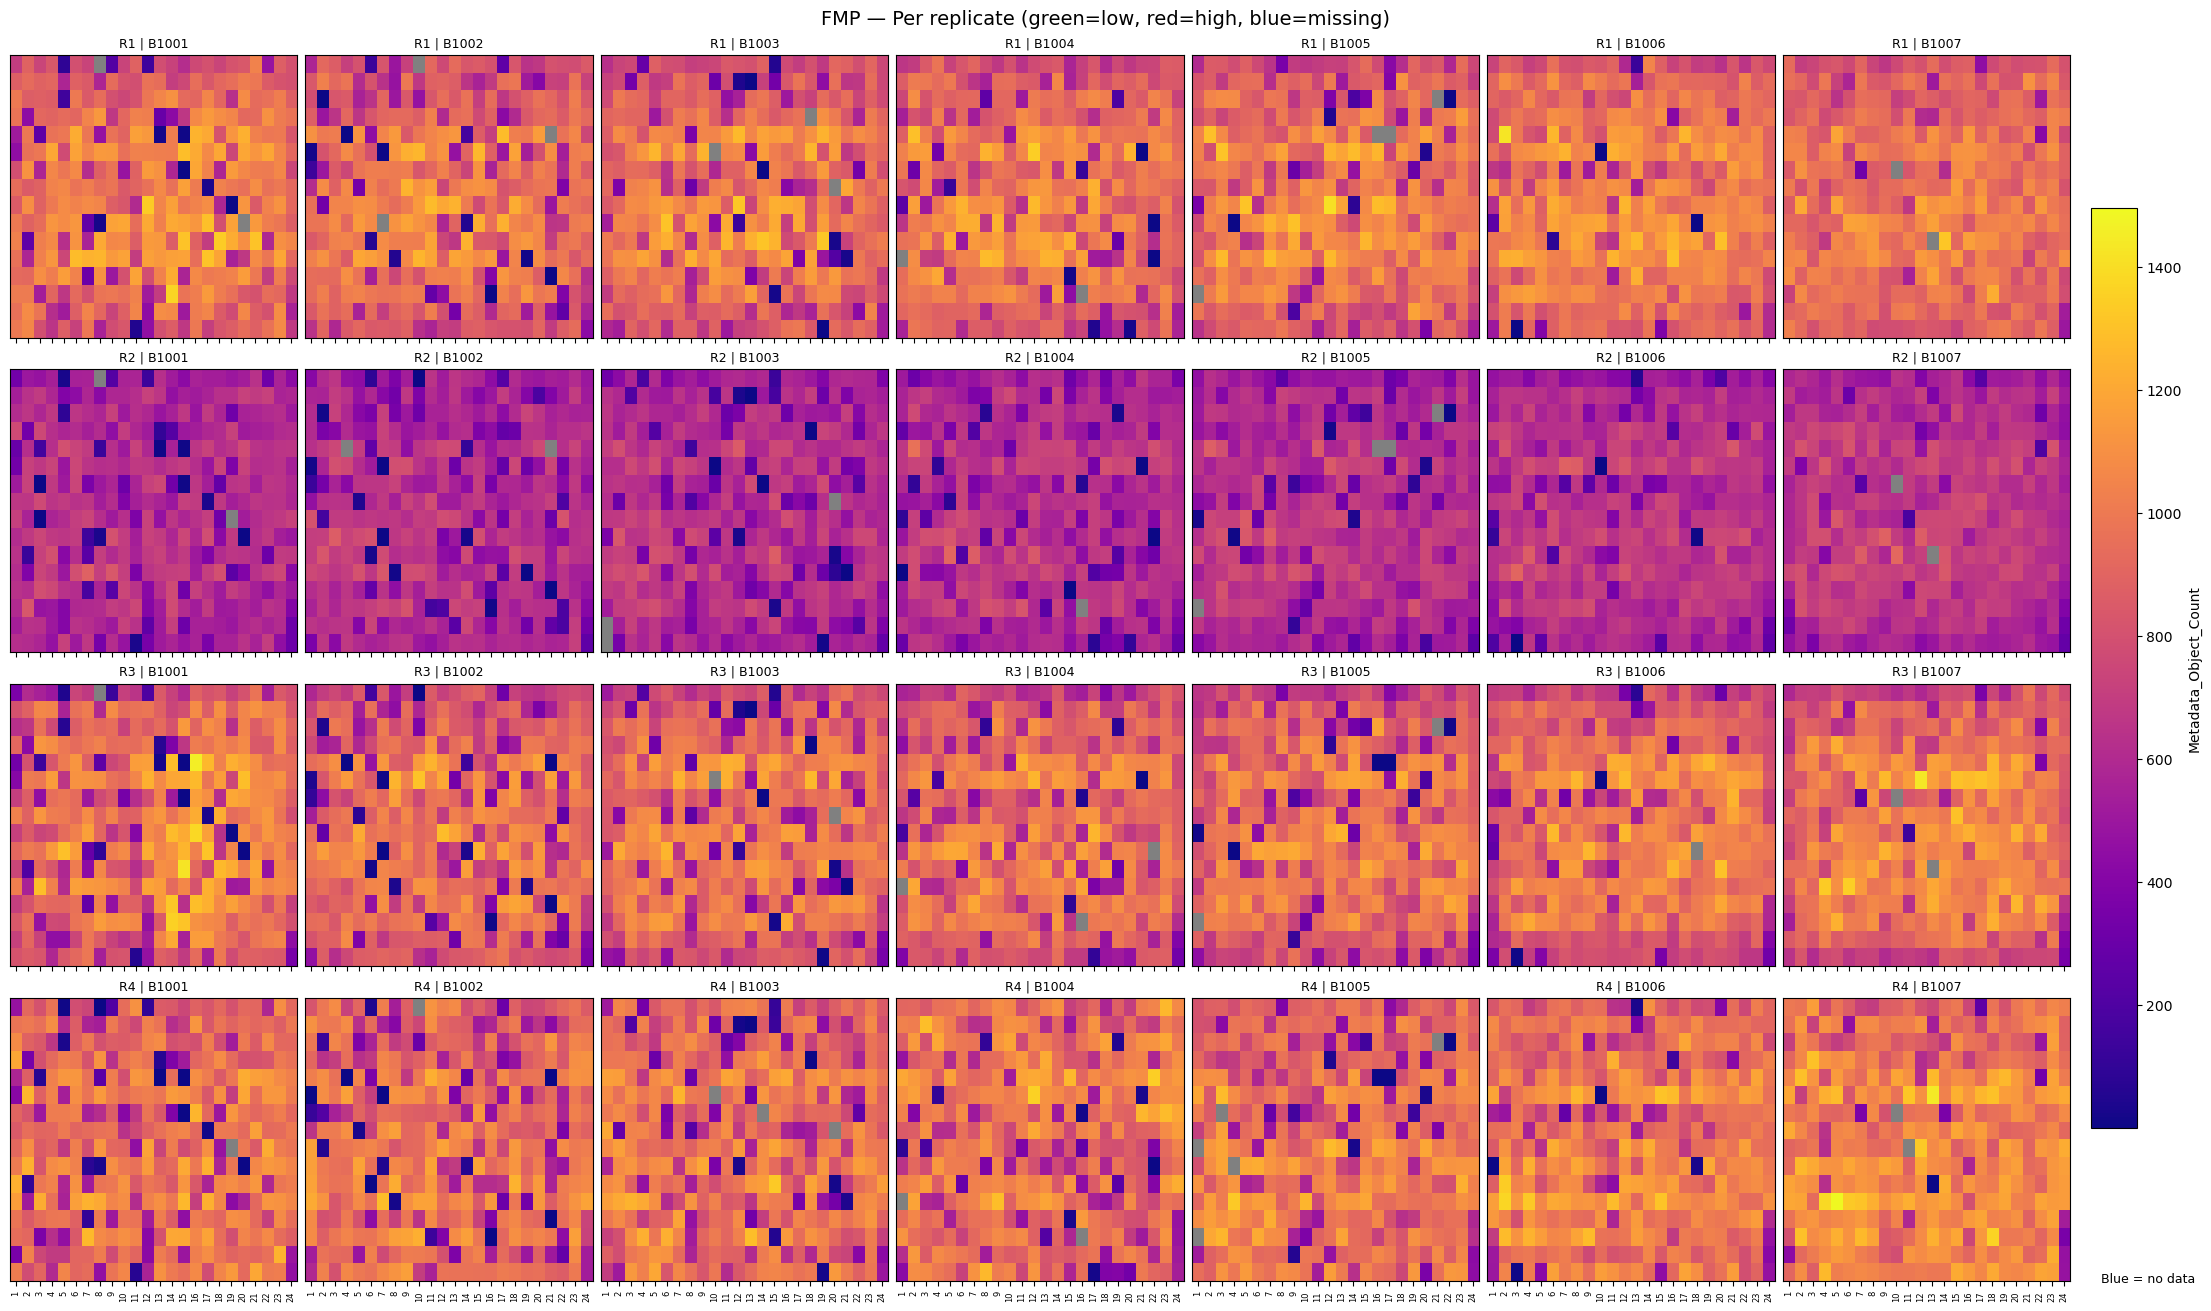

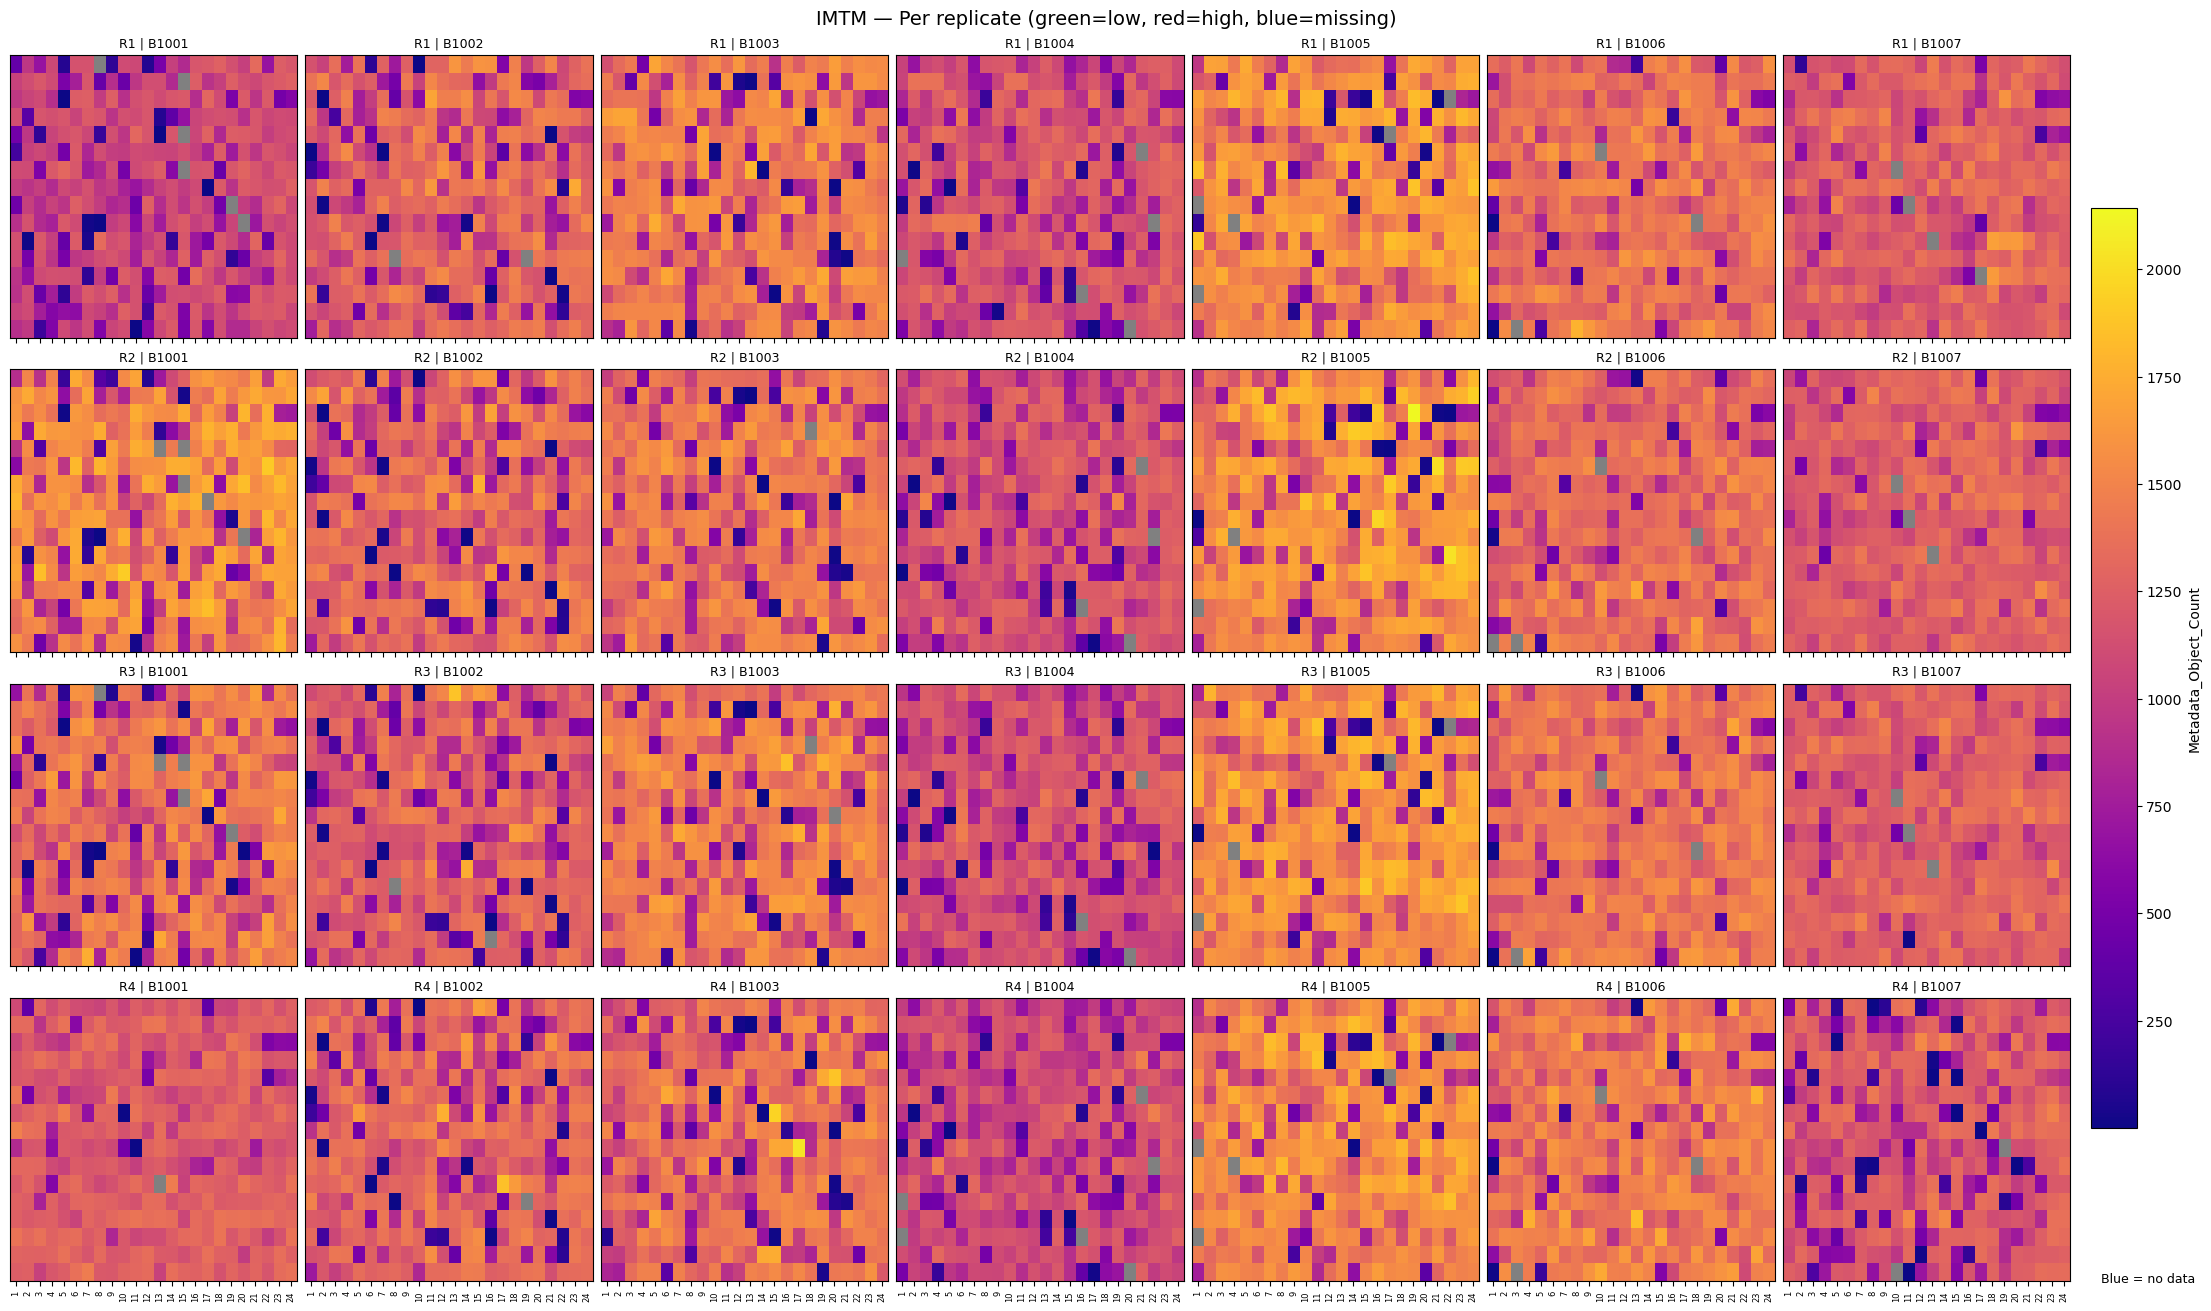

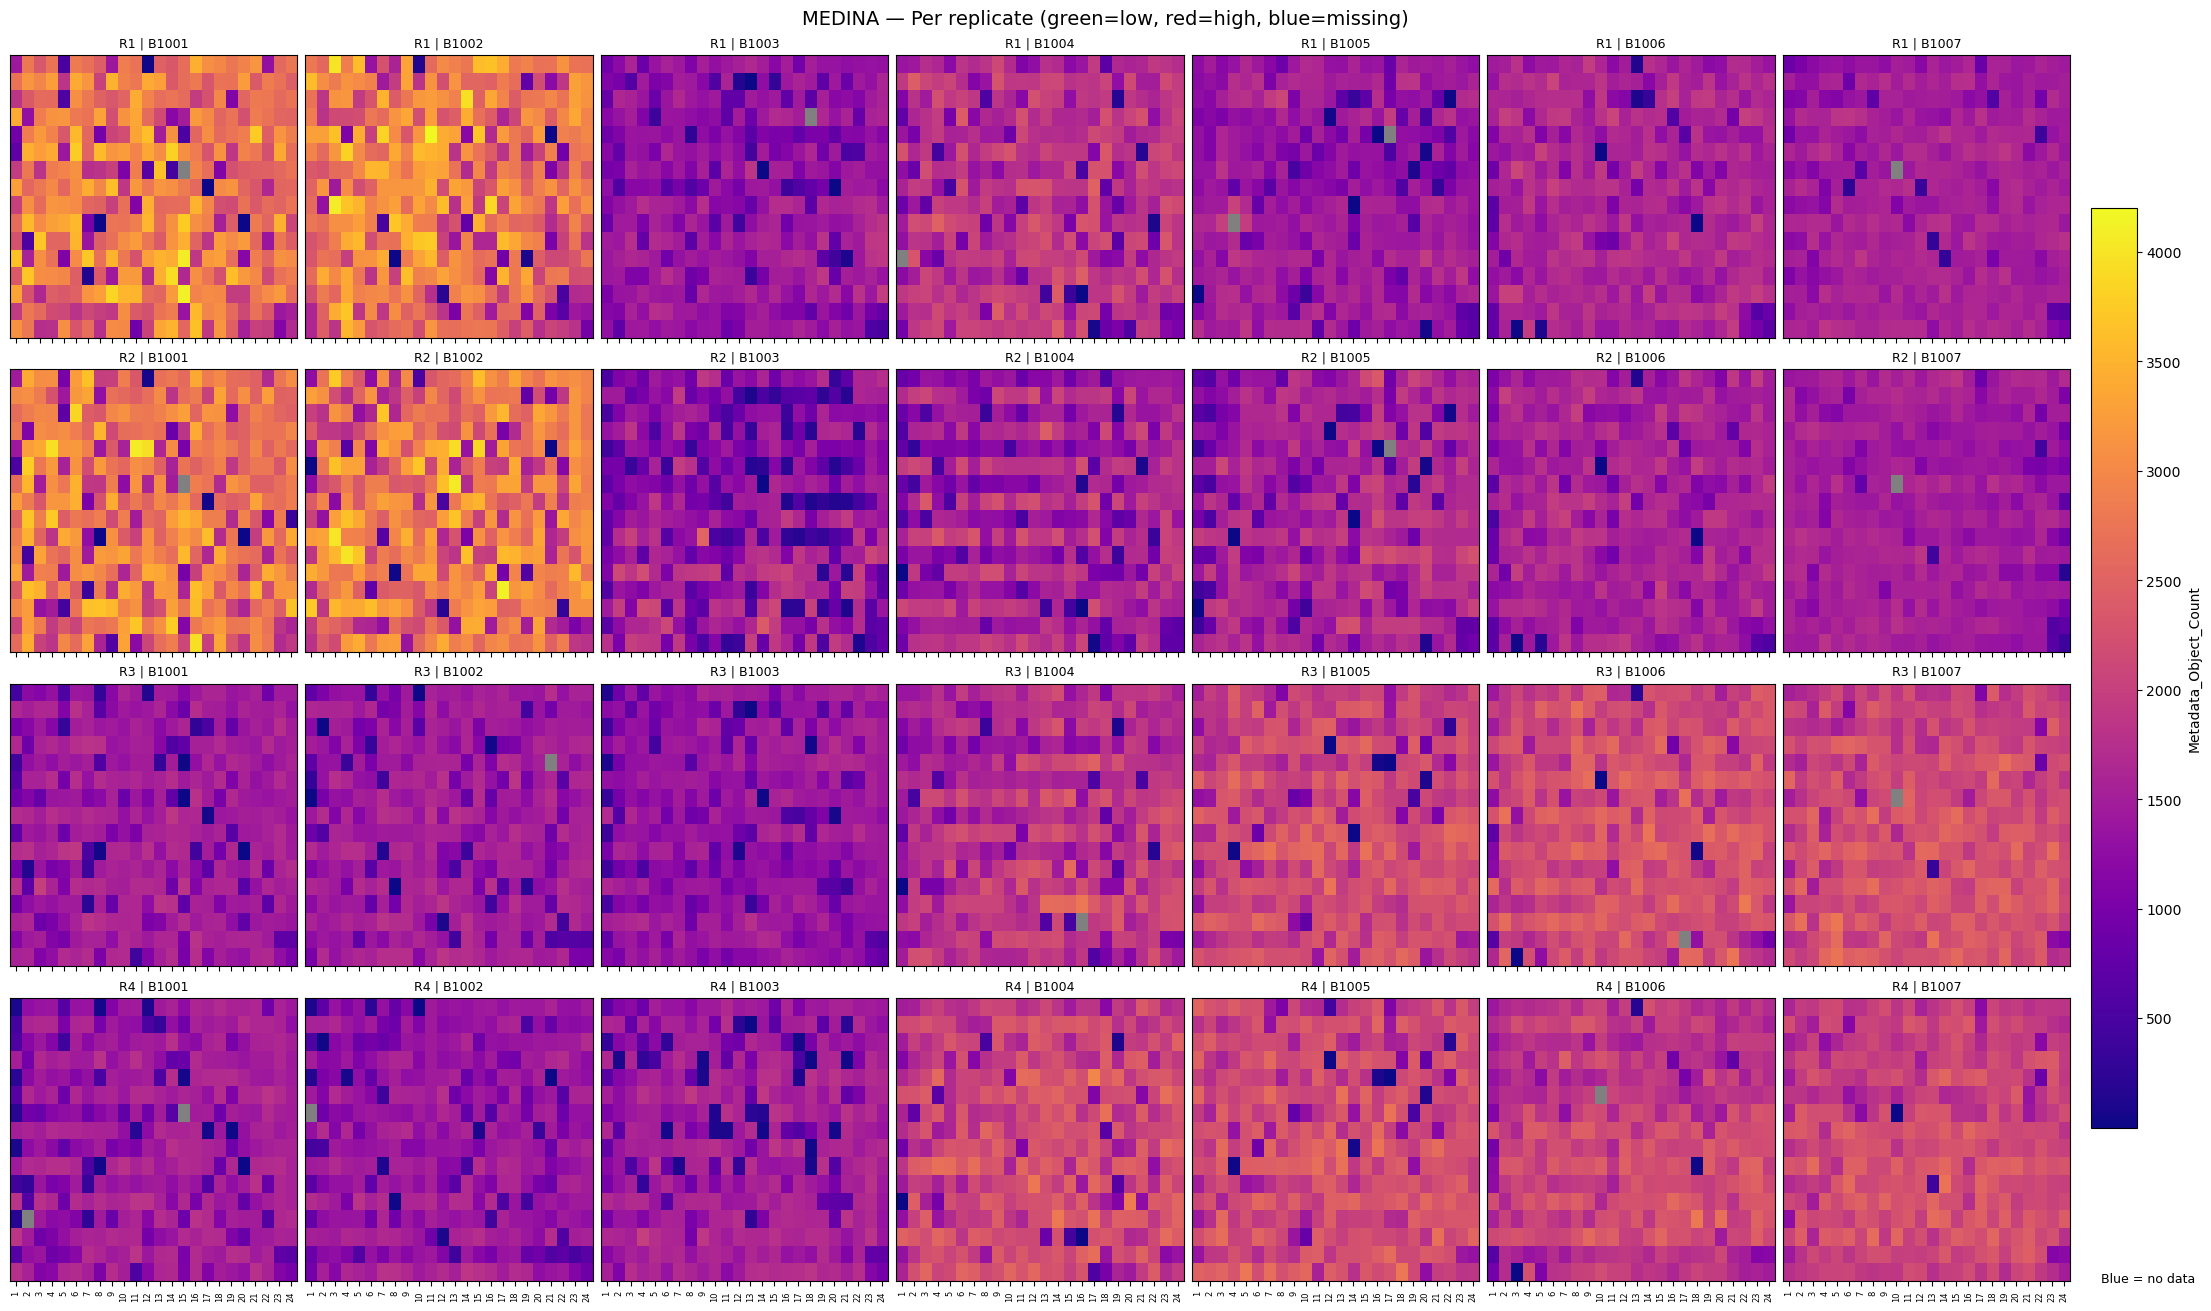

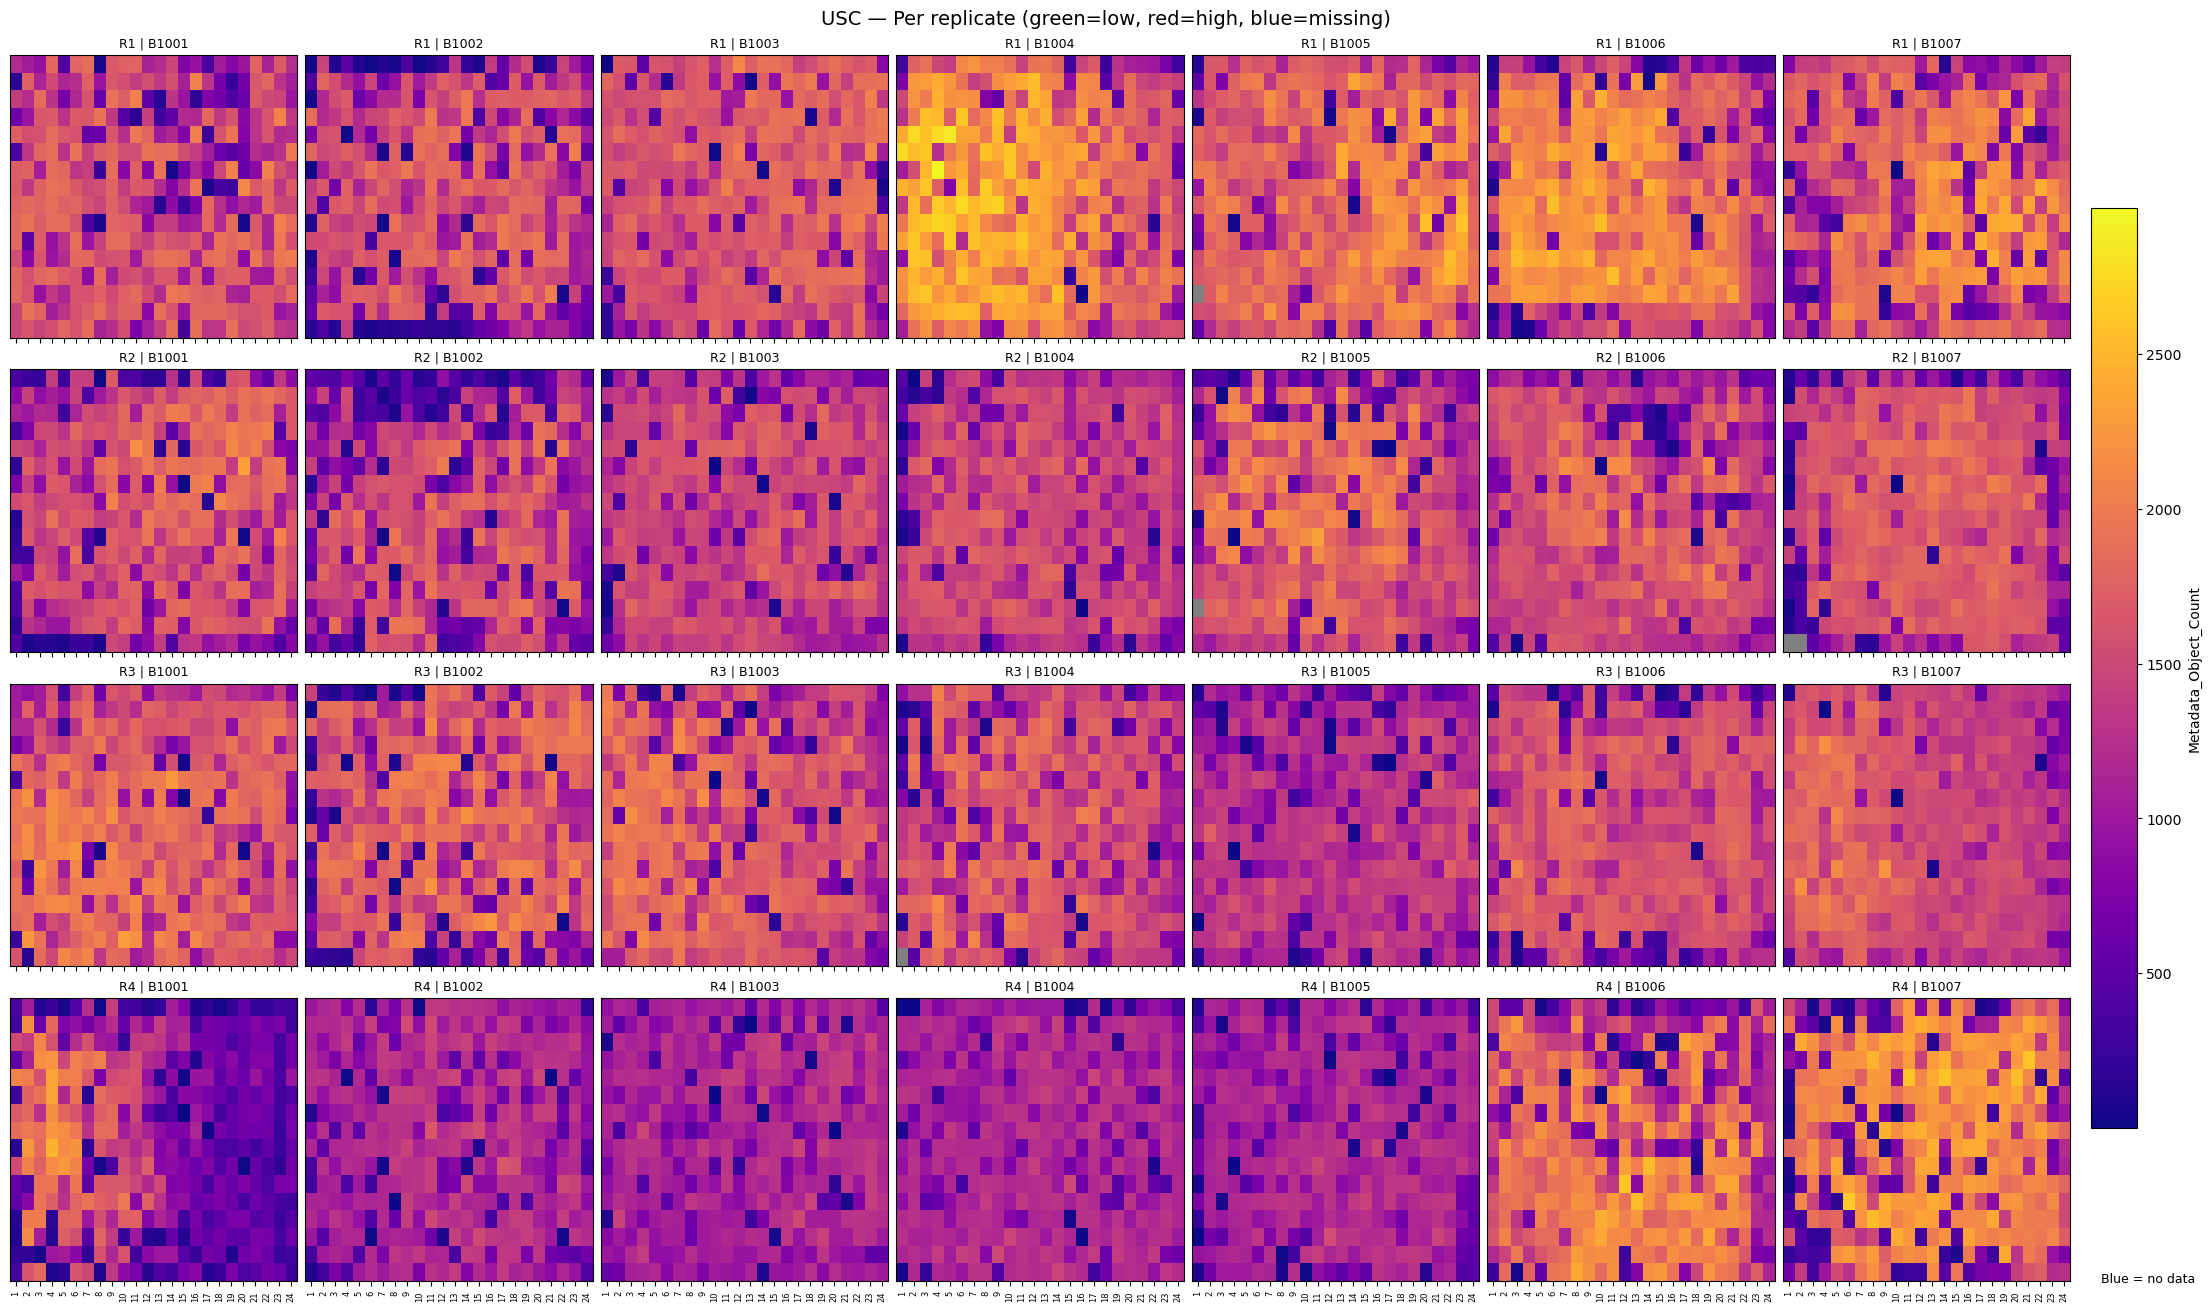

<Figure size 640x480 with 0 Axes>

In [112]:
# How to use: 
# mode indicates level of granularity: "per_replicate" - 4x4x7, "collapsed" - 4x7, "combined_sites" - 1x7.
# color_scale indicates how the heatmaps are colored. "global" compares to min/max cell count of entire dataset.
# In per-replicate mode "site" compares to min/max cell count of the site.
# In collapsed mode "site" compares to min/max cell count of the site.
# In combined_sites mode "site" compares to min/max cell count of the average cell count for each (plaet, letter, number) tuple across sites and replicates.


plot_well_heatmaps(df_small, mode="per_replicate", color_scale="site", save=True, outdir="plots")


## Task 1:

/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_69779/926641250.py:125: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=labels, showfliers=False)


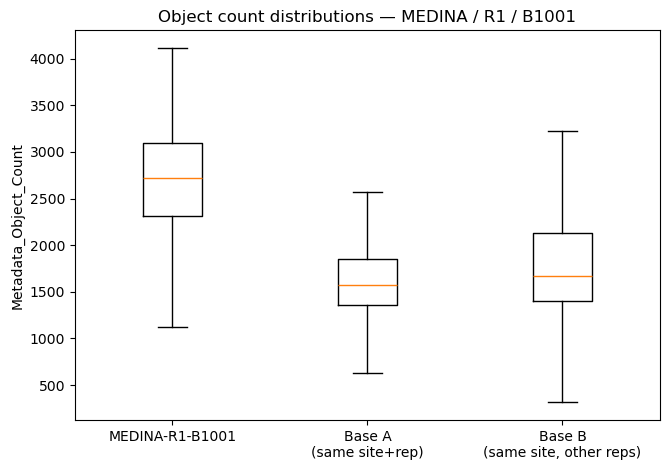

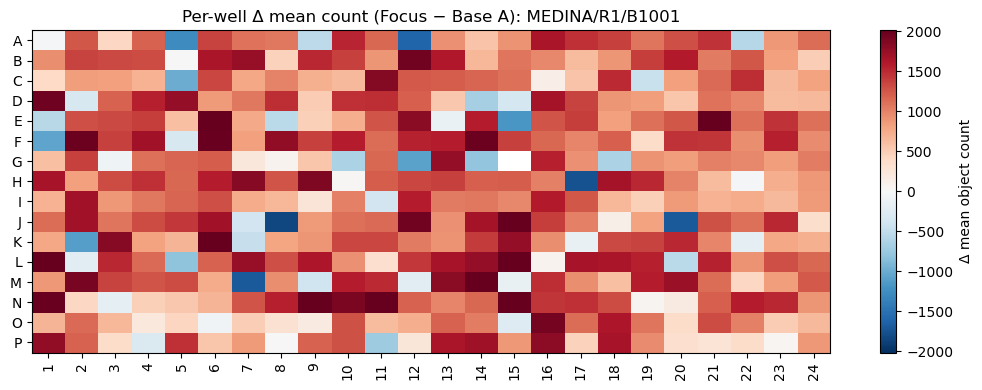

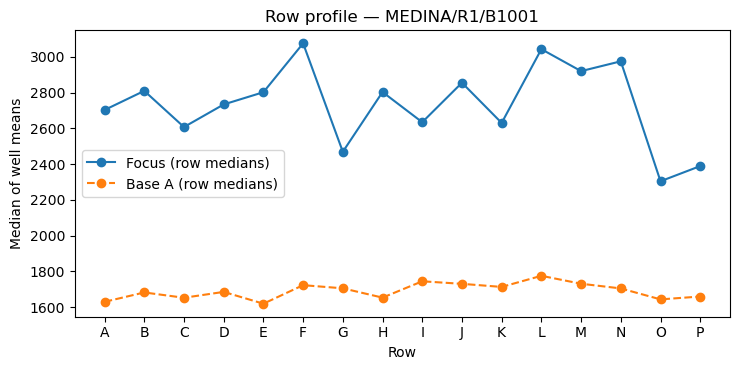

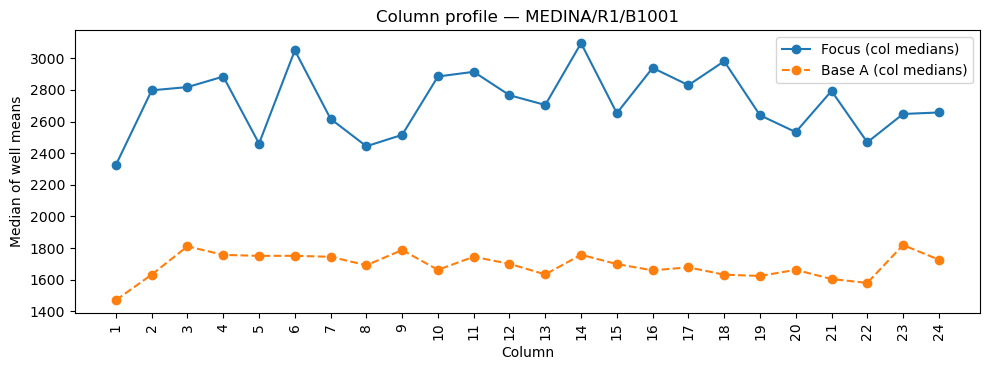

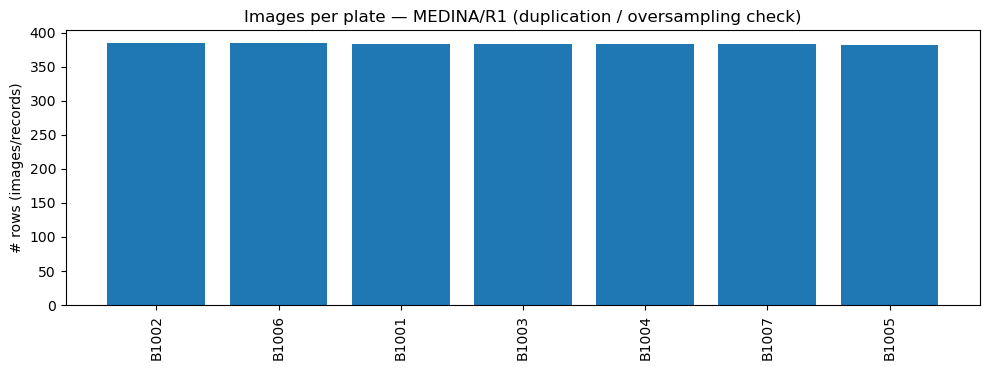

/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_69779/926641250.py:125: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=labels, showfliers=False)


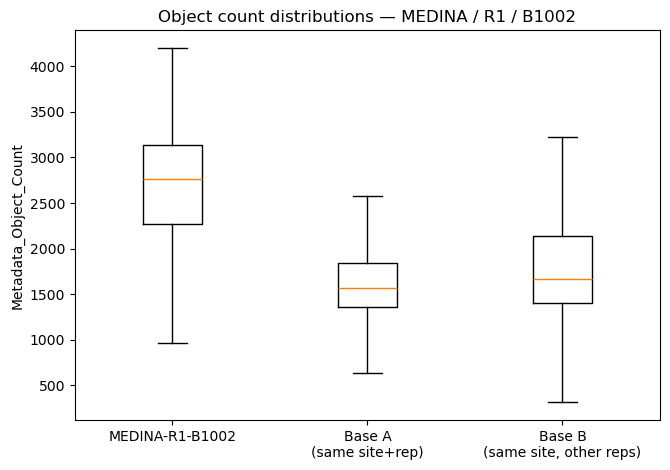

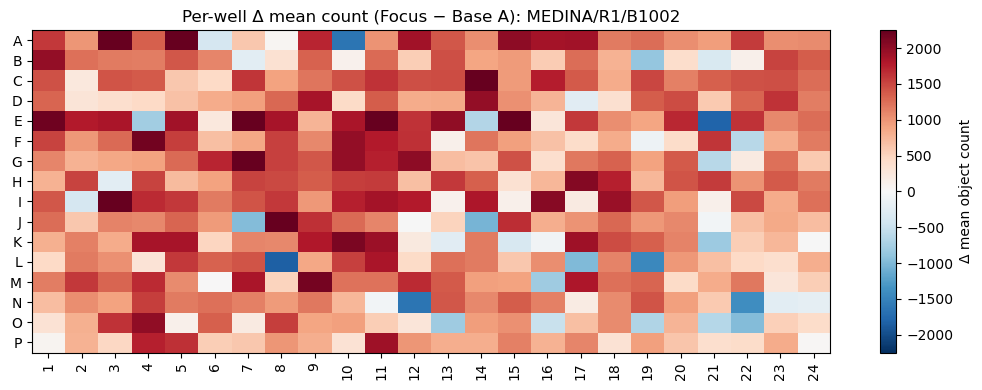

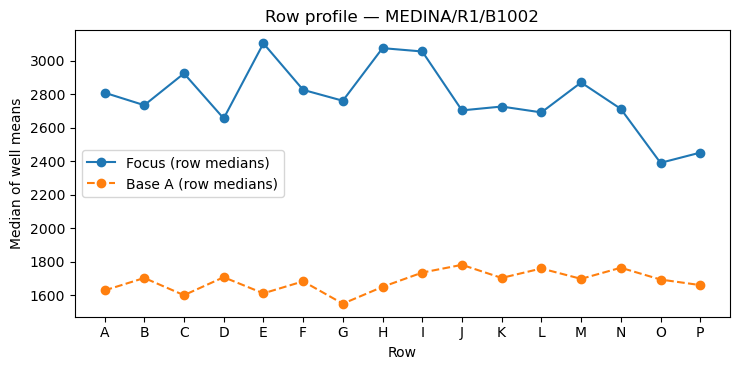

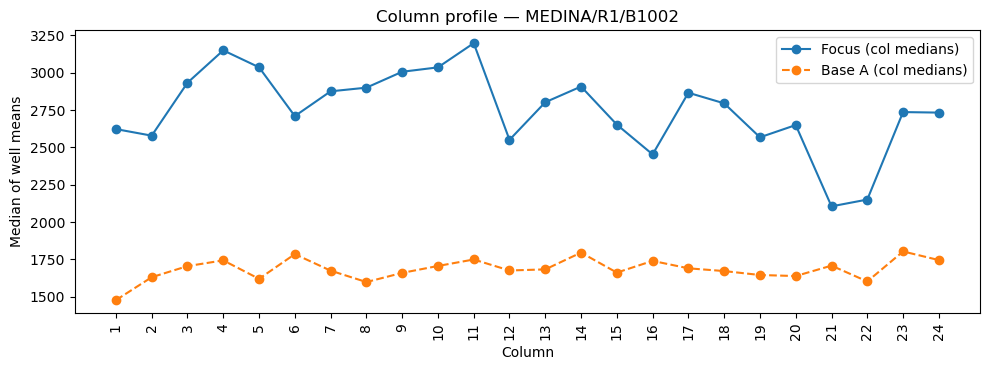

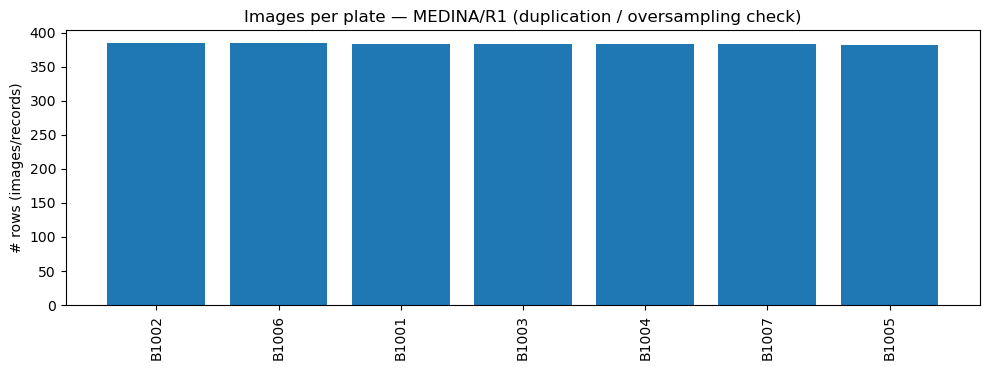

/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_69779/926641250.py:125: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=labels, showfliers=False)


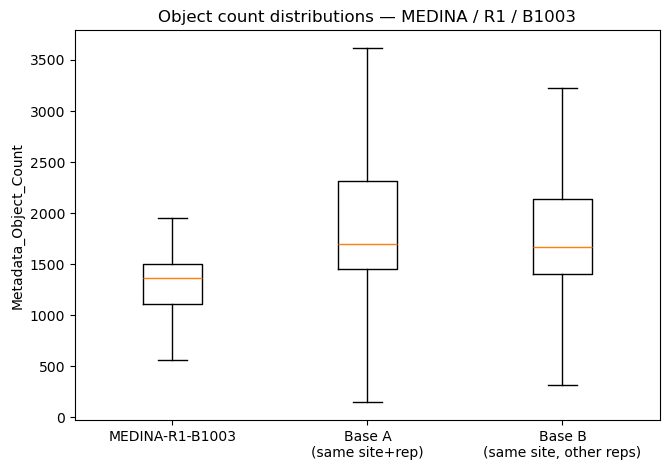

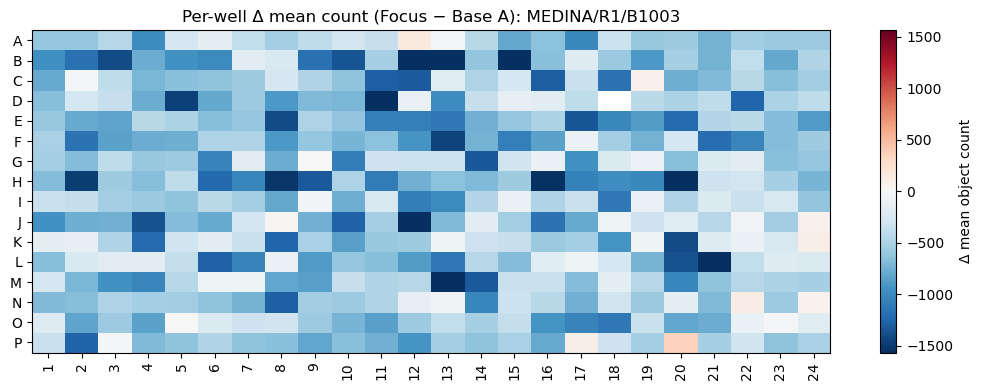

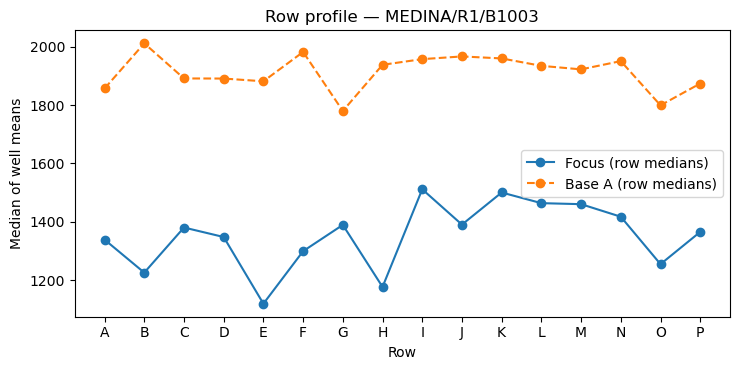

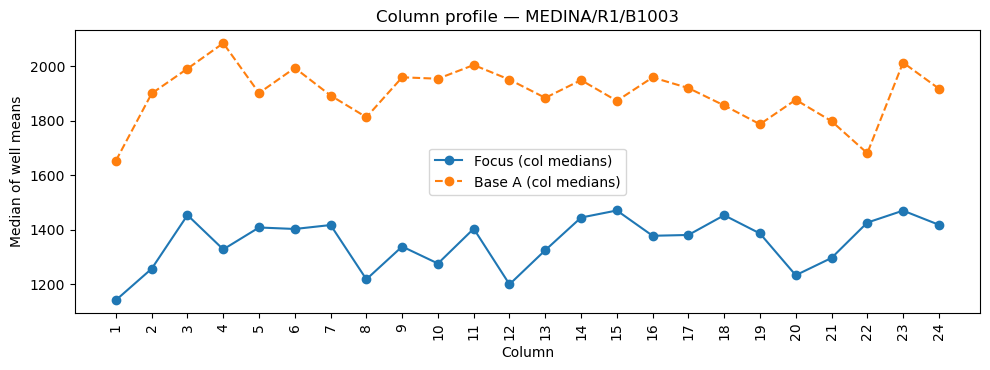

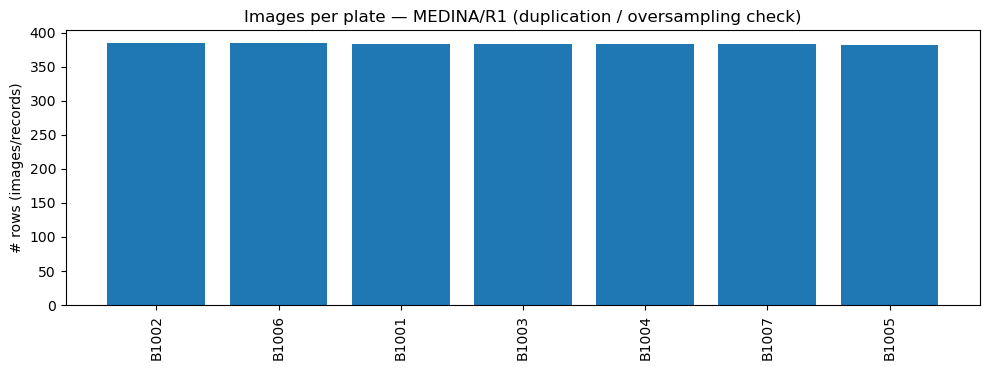

/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_69779/926641250.py:125: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=labels, showfliers=False)


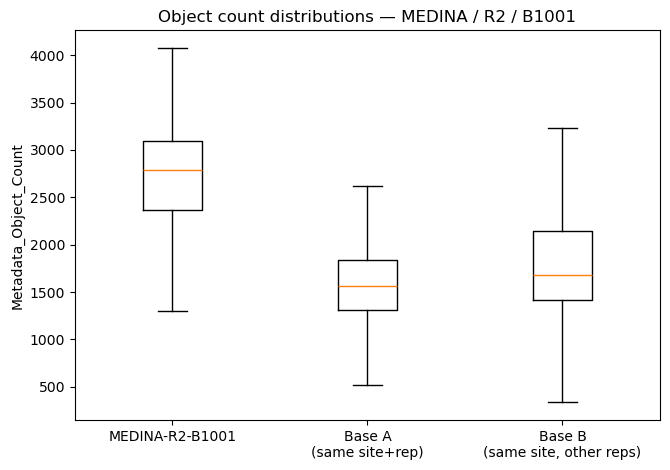

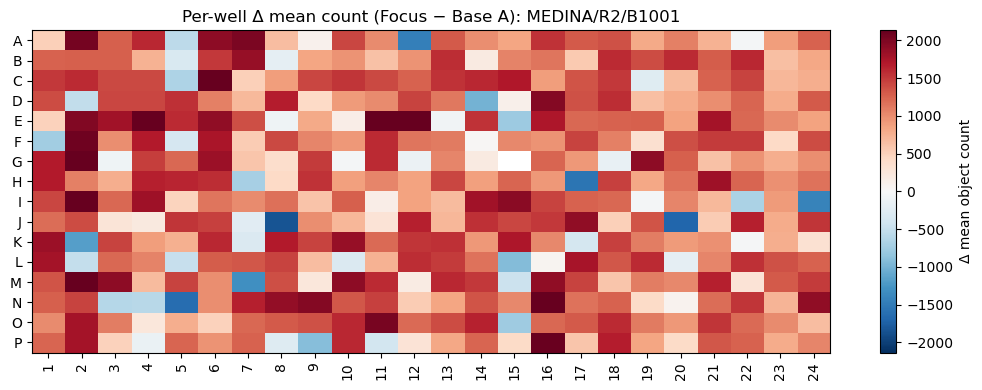

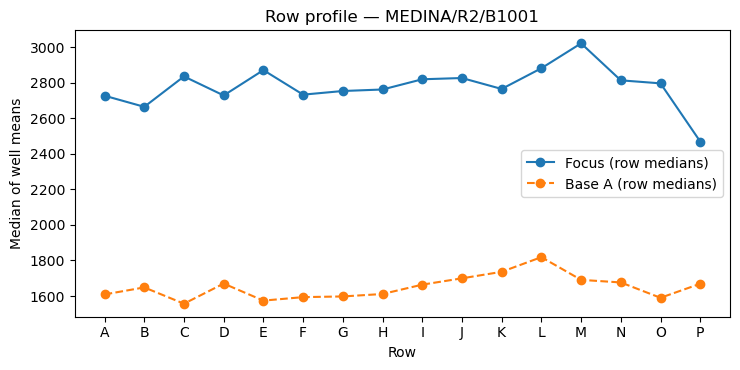

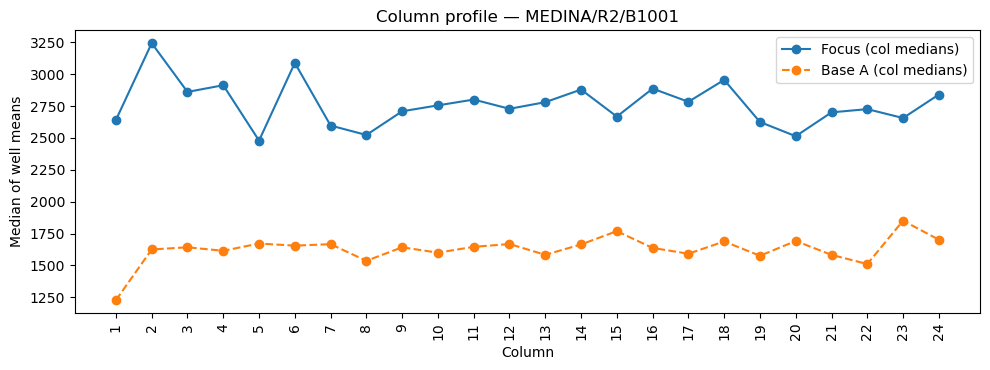

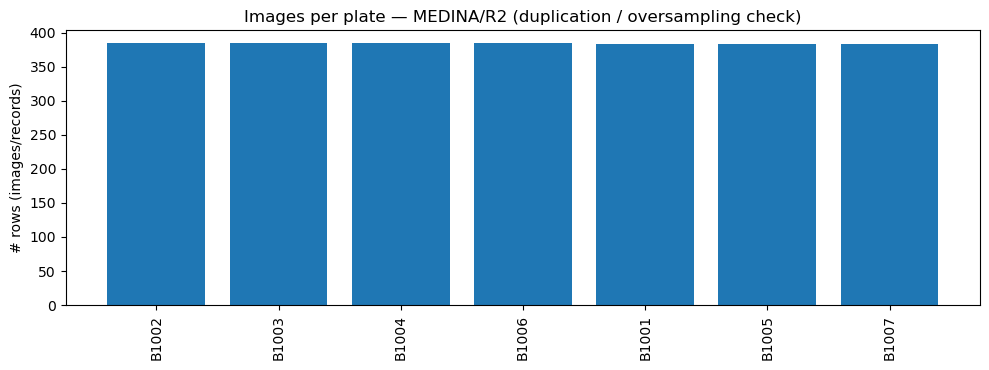

/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_69779/926641250.py:125: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=labels, showfliers=False)


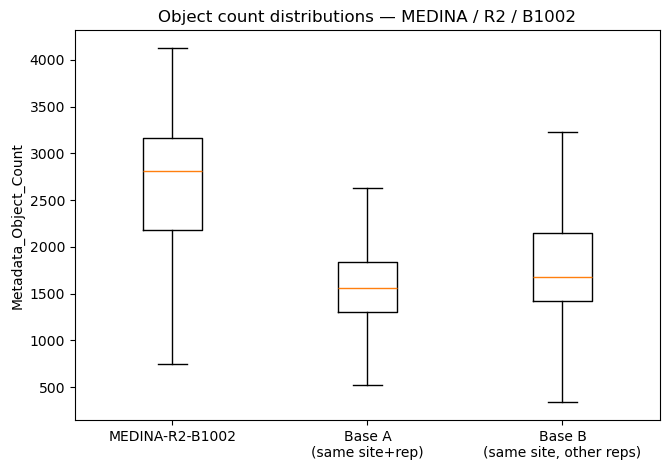

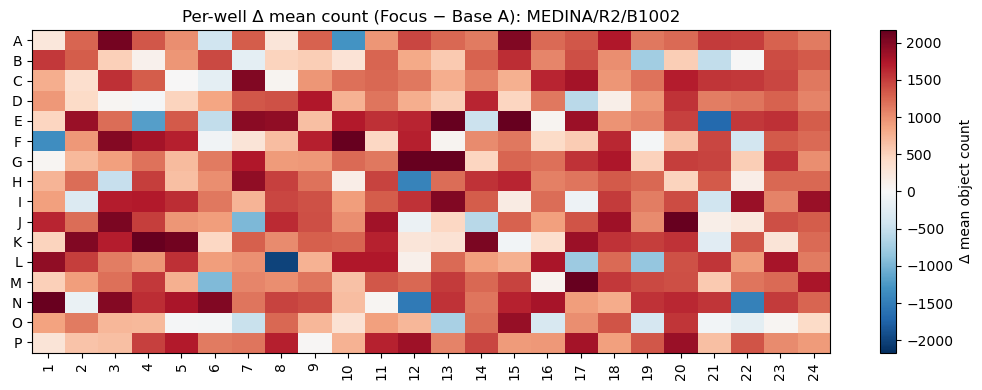

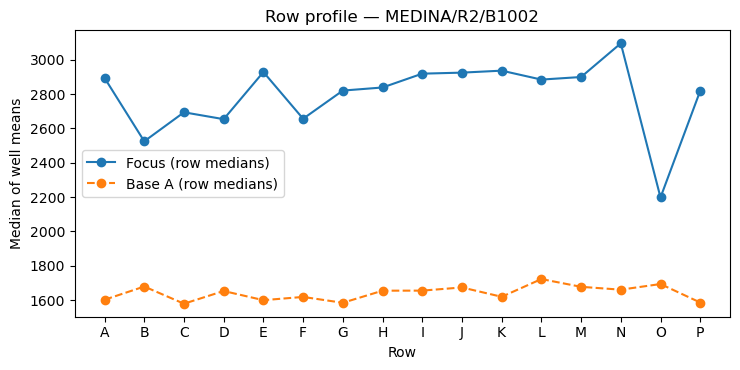

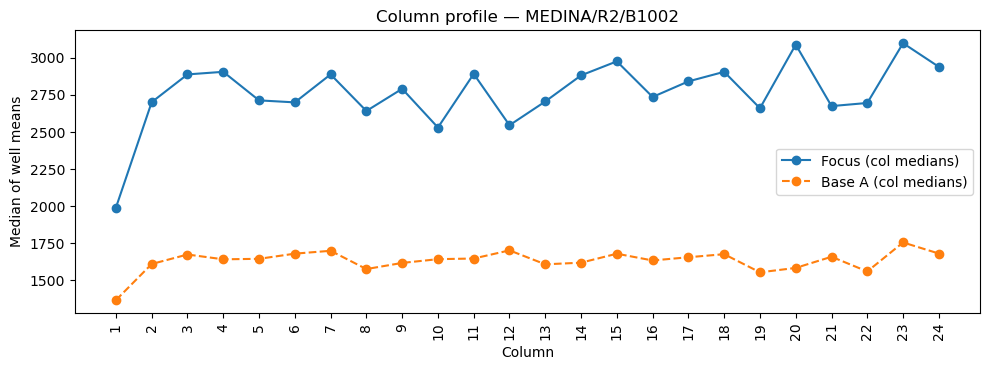

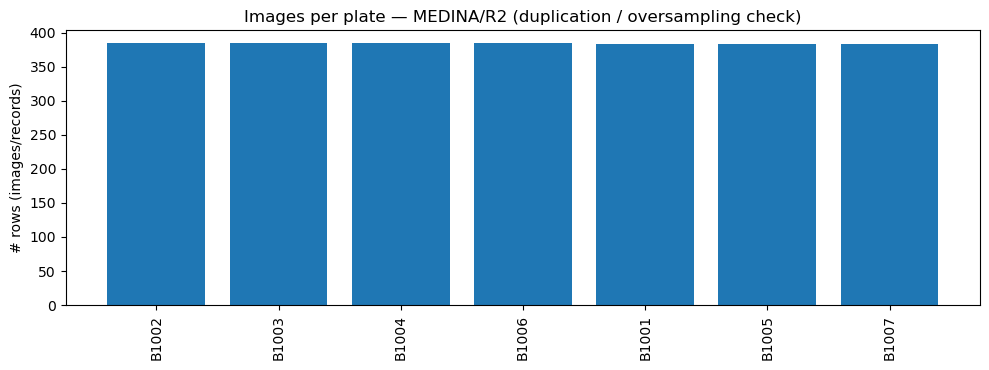

In [10]:
def plot_well_heatmaps(df_small,
                       mode: str = "per_replicate",
                       color_scale: str = "site",
                       sites=("FMP","IMTM","MEDINA","USC"),
                       plates=tuple(f"B100{i}" for i in range(1,8)),
                       save: bool = False,
                       outdir: str = "plots"):
    assert mode in {"per_replicate","collapsed","combined_sites"}
    assert color_scale in {"site","global"}

    letters = [chr(ord("A")+i) for i in range(16)]
    letter_to_idx = {L:i for i,L in enumerate(letters)}
    numbers = list(range(1,25))
    replicates = ["R1","R2","R3","R4"]

    data = df_small.copy()
    data["Metadata_Row"] = data["Metadata_Row"].astype(str).str.upper()
    data["Metadata_Col"] = pd.to_numeric(data["Metadata_Col"], errors="coerce")
    data["Metadata_Object_Count"] = pd.to_numeric(data["Metadata_Object_Count"], errors="coerce")
    data = data[data["Metadata_Row"].isin(letters) & data["Metadata_Col"].between(1,24)]

    if color_scale == "global":
        vmin_glob = data["Metadata_Object_Count"].min()
        vmax_glob = data["Metadata_Object_Count"].max()
        if pd.isna(vmin_glob) or pd.isna(vmax_glob) or vmin_glob == vmax_glob:
            vmin_glob, vmax_glob = 0.0, 1.0

    cmap = plt.cm.get_cmap("plasma").copy()
    cmap.set_bad(color="grey")

    def make_grid(sub_df: pd.DataFrame) -> np.ndarray:
        grid = np.full((16,24), np.nan, dtype=float)
        if not sub_df.empty:
            g = sub_df.groupby(["Metadata_Row","Metadata_Col"])["Metadata_Object_Count"].mean()
            for (r,c), v in g.items():
                grid[letter_to_idx[r], int(c)-1] = v
        return grid

    if save:
        Path(outdir).mkdir(parents=True, exist_ok=True)

    if mode == "per_replicate":
        for site in sites:
            site_df = data[(data["Metadata_Site"]==site) &
                           (data["Metadata_Plate_num"].isin(plates)) &
                           (data["Metadata_Replicate"].isin(replicates))]

            if color_scale == "site":
                vmin = site_df["Metadata_Object_Count"].min()
                vmax = site_df["Metadata_Object_Count"].max()
                if pd.isna(vmin) or pd.isna(vmax) or vmin == vmax: vmin, vmax = 0.0, 1.0
            else:
                vmin, vmax = vmin_glob, vmax_glob

            fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(22, 13), constrained_layout=True, sharex=True, sharey=True)
            fig.suptitle(f"{site} — Per replicate (green=low, red=high, blue=missing)", fontsize=14)

            for r_idx, rep in enumerate(replicates):
                for p_idx, plate in enumerate(plates):
                    ax = axes[r_idx, p_idx]
                    sub = site_df[(site_df["Metadata_Replicate"]==rep) & (site_df["Metadata_Plate_num"]==plate)]
                    ax.imshow(make_grid(sub), interpolation="nearest", cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax), aspect="auto")
                    ax.set_title(f"{rep} | {plate}", fontsize=9)
                    if p_idx == 0:
                        ax.set_yticks(range(16)); ax.set_yticklabels(letters, fontsize=7)
                    else:
                        ax.set_yticks([])
                    if r_idx == 3:
                        ax.set_xticks(range(24)); ax.set_xticklabels(numbers, fontsize=6, rotation=90)
                    else:
                        ax.set_xticks([])

            sm = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=cmap); sm.set_array([])
            fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.75, pad=0.01).set_label("Metadata_Object_Count")
            fig.text(0.995, 0.02, "Blue = no data", ha="right", va="center", fontsize=9)
            if save:
                fname = Path(outdir) / f"{site}_per_replicate_4x7.pdf"
                fig.savefig(fname, dpi=1000, bbox_inches="tight")
            plt.show()
            plt.close(fig)
        plt.savefig("my_plot.pdf")
        return

    if mode == "collapsed":
        collapsed = (data.groupby(["Metadata_Site","Metadata_Plate_num","Metadata_Row","Metadata_Col"], as_index=False)
                          ["Metadata_Object_Count"].mean())

        for site in sites:
            site_df = collapsed[(collapsed["Metadata_Site"]==site) & (collapsed["Metadata_Plate_num"].isin(plates))]

            if color_scale == "site":
                vmin = site_df["Metadata_Object_Count"].min()
                vmax = site_df["Metadata_Object_Count"].max()
                if pd.isna(vmin) or pd.isna(vmax) or vmin == vmax: vmin, vmax = 0.0, 1.0
            else:
                vmin, vmax = vmin_glob, vmax_glob

            fig, axes = plt.subplots(1, 7, figsize=(22, 4.5), constrained_layout=True, sharex=True, sharey=True)
            fig.suptitle(f"{site} — Average per well (replicates collapsed)", fontsize=14)

            for p_idx, plate in enumerate(plates):
                ax = axes[p_idx]
                sub = site_df[site_df["Metadata_Plate_num"]==plate]
                ax.imshow(make_grid(sub), interpolation="nearest", cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax), aspect="auto")
                ax.set_title(plate, fontsize=10)
                if p_idx == 0:
                    ax.set_yticks(range(16)); ax.set_yticklabels(letters, fontsize=7)
                else:
                    ax.set_yticks([])
                if p_idx == len(plates)-1:
                    ax.set_xticks(range(24)); ax.set_xticklabels(numbers, fontsize=6, rotation=90)
                else:
                    ax.set_xticks([])

            sm = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=cmap); sm.set_array([])
            fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.8, pad=0.01).set_label("Average Metadata_Object_Count")
            fig.text(0.995, 0.02, "Blue = no data", ha="right", va="center", fontsize=9)
            if save:
                fname = Path(outdir) / f"{site}_per_replicate_4x7.pdf"
                fig.savefig(fname, dpi=300, bbox_inches="tight")
            plt.show()
            plt.close(fig)

        return

    combined = (data.groupby(["Metadata_Plate_num","Metadata_Row","Metadata_Col"], as_index=False)
                     ["Metadata_Object_Count"].mean())

    if color_scale == "site":
        vmin = combined["Metadata_Object_Count"].min()
        vmax = combined["Metadata_Object_Count"].max()
        if pd.isna(vmin) or pd.isna(vmax) or vmin == vmax: vmin, vmax = 0.0, 1.0
    else:
        vmin, vmax = vmin_glob, vmax_glob

    fig, axes = plt.subplots(1, 7, figsize=(22, 4.5), constrained_layout=True, sharex=True, sharey=True)
    fig.suptitle("All sites combined — Average per well", fontsize=14)

    for p_idx, plate in enumerate(plates):
        ax = axes[p_idx]
        sub = combined[combined["Metadata_Plate_num"]==plate]
        ax.imshow(make_grid(sub), interpolation="nearest", cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax), aspect="auto")
        ax.set_title(plate, fontsize=10)
        if p_idx == 0:
            ax.set_yticks(range(16)); ax.set_yticklabels(letters, fontsize=7)
        else:
            ax.set_yticks([])
        if p_idx == len(plates)-1:
            ax.set_xticks(range(24)); ax.set_xticklabels(numbers, fontsize=6, rotation=90)
        else:
            ax.set_xticks([])

    sm = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=cmap); sm.set_array([])
    fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.8, pad=0.01).set_label("Average Metadata_Object_Count (all sites)")
    fig.text(0.995, 0.02, "Blue = no data", ha="right", va="center", fontsize=9)
    plt.savefig("my_plot.pdf")
    plt.show()


In [11]:
df

,Metadata_Well,Metadata_Object_Count,Nuc_AreaShape_Area,Nuc_AreaShape_BoundingBoxArea,Nuc_AreaShape_BoundingBoxMaximum_X,Nuc_AreaShape_BoundingBoxMaximum_Y,Nuc_AreaShape_BoundingBoxMinimum_X,Nuc_AreaShape_BoundingBoxMinimum_Y,Nuc_AreaShape_Center_X,Nuc_AreaShape_Center_Y,...,Metadata_Unique_plate,Metadata_EOS,Metadata_Concentration,Metadata_Partner,Metadata_Row,Metadata_Col,Metadata_Compound_type,Metadata_DMSO,Metadata_Nocodazole,Metadata_Tetrandrine
0,A01,700,665.0,905.0,536.5,509.5,506.5,480.5,523.011597,494.002640,...,HepG_FMP_B1001_R1,EOS100001,10,Bioactives,A,1,EOS,False,False,False
1,A02,890,627.5,864.0,519.0,514.0,487.0,481.0,504.911392,496.798447,...,HepG_FMP_B1001_R1,EOS100089,10,Bioactives,A,2,EOS,False,False,False
2,A03,742,631.5,899.0,551.0,576.5,516.5,542.5,535.364777,556.941528,...,HepG_FMP_B1001_R1,EOS100009,10,Bioactives,A,3,EOS,False,False,False
3,A04,840,606.0,840.0,593.5,542.5,560.0,514.5,574.513031,528.910034,...,HepG_FMP_B1001_R1,EOS100097,10,Bioactives,A,4,EOS,False,False,False
4,A05,91,506.0,690.0,452.0,549.0,427.0,529.0,440.138550,538.330505,...,HepG_FMP_B1001_R1,EOS100017,10,Bioactives,A,5,EOS,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42842,P20,1105,458.0,624.0,580.0,601.0,555.0,574.0,566.545288,588.128296,...,HepG_USC_B1007_R2,EOS102456,10,Bioactives,P,20,EOS,False,False,False
42843,P21,1293,433.0,598.0,531.0,638.0,507.0,605.0,518.472046,621.702759,...,HepG_USC_B1007_R2,EOS102376,10,Bioactives,P,21,EOS,False,False,False
42844,P22,1355,429.0,580.0,563.0,522.0,536.0,494.0,547.828003,506.057129,...,HepG_USC_B1007_R2,EOS102464,10,Bioactives,P,22,EOS,False,False,False
42845,P23,1445,372.0,506.0,579.0,540.0,550.0,511.0,563.848877,525.885315,...,HepG_USC_B1007_R2,Tetrandrine,5,Bioactives,P,23,Tetrandrine,False,False,True


In [12]:
df_a = df[df['Metadata_Unique_plate'] == 'HepG_MEDINA_B1001_R1']

In [13]:
df_b = df[df['Metadata_Unique_plate'] == 'HepG_MEDINA_B1001_R3']

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

def _bh_fdr(pvals):
    p = np.asarray(pvals, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    q = ranked * n / (np.arange(1, n+1))
    q = np.minimum.accumulate(q[::-1])[::-1]
    out = np.empty_like(q)
    out[order] = q
    return np.minimum(out, 1.0)

def compare_dataframes(df1, df2):
    cols = [c for c in df1.columns if c in df2.columns]
    results = []

    for col in cols:
        s1 = df1[col].dropna()
        s2 = df2[col].dropna()
        if len(s1) == 0 or len(s2) == 0:
            continue

        kind = None
        test_name = None
        pval = np.nan
        effect = np.nan
        extra = {}

        if np.issubdtype(s1.dtype, np.number) and np.issubdtype(s2.dtype, np.number):
            kind = 'numeric'
        else:
            s1 = s1.astype('object')
            s2 = s2.astype('object')
            uniq = pd.Index(pd.unique(pd.concat([s1, s2], ignore_index=True)))
            if len(uniq) == 2:
                kind = 'binary'
            else:
                kind = 'categorical'

        if kind == 'numeric':
            t, pval = stats.ttest_ind(s1, s2, equal_var=False, nan_policy='omit')
            m1, m2 = np.mean(s1), np.mean(s2)
            v1, v2 = np.var(s1, ddof=1), np.var(s2, ddof=1)
            n1, n2 = len(s1), len(s2)
            sp2 = ((n1-1)*v1 + (n2-1)*v2) / (n1 + n2 - 2) if (n1+n2-2) > 0 else np.nan
            sd_pooled = np.sqrt(sp2) if sp2 >= 0 else np.nan
            effect = (m1 - m2) / sd_pooled if sd_pooled and sd_pooled > 0 else np.nan
            extra = {
                'mean_df1': m1, 'mean_df2': m2,
                'diff_means': m1 - m2,
                'sd_df1': np.sqrt(v1), 'sd_df2': np.sqrt(v2),
                'n_df1': n1, 'n_df2': n2
            }
            test_name = 'Welch t-test (means)'

        elif kind == 'binary':
            uniq = pd.Index(pd.unique(pd.concat([s1, s2], ignore_index=True)))
            if not (set(uniq) <= {0, 1}):
                ref = uniq.sort_values()[0]
                s1 = (s1 == ref).astype(int)
                s2 = (s2 == ref).astype(int)
            x1, n1 = int(s1.sum()), len(s1)
            x2, n2 = int(s2.sum()), len(s2)
            p1, p2 = x1/n1, x2/n2
            p_pool = (x1 + x2) / (n1 + n2)
            se = np.sqrt(p_pool*(1-p_pool)*(1/n1 + 1/n2))
            if se == 0:
                z = np.inf if p1 != p2 else 0.0
                pval = 0.0 if np.isfinite(z) and z != 0 else 1.0
            else:
                z = (p1 - p2) / se
                pval = 2 * (1 - stats.norm.cdf(abs(z)))
            effect = p1 - p2
            extra = {'prop_df1': p1, 'prop_df2': p2, 'n_df1': n1, 'n_df2': n2}
            test_name = 'Two-proportion z-test'

        else:
            cats = pd.Index(pd.unique(pd.concat([s1, s2], ignore_index=True)))
            c1 = pd.value_counts(pd.Categorical(s1, categories=cats))
            c2 = pd.value_counts(pd.Categorical(s2, categories=cats))
            table = np.vstack([c1.values, c2.values])
            chi2, pval, dof, exp = stats.chi2_contingency(table, correction=False)
            n = table.sum()
            k = min(table.shape) - 1
            effect = np.sqrt(chi2 / (n * k)) if n > 0 and k > 0 else np.nan
            extra = {'levels': list(cats), 'counts_df1': list(c1.values), 'counts_df2': list(c2.values)}
            test_name = 'Chi-square (distribution)'

        results.append({
            'column': col,
            'type': kind,
            'test': test_name,
            'p_value': pval,
            'effect_size': effect,
            **extra
        })

    out = pd.DataFrame(results)
    if out.empty:
        return out

    out['p_adj_fdr_bh'] = _bh_fdr(out['p_value'].values)
    out = out.sort_values(['p_adj_fdr_bh', 'p_value'], ascending=True).reset_index(drop=True)
    return out


In [15]:
summary = compare_dataframes(df_a, df_b)
summary.head(20)  # top differences


/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_69779/899871460.py:92: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  c1 = pd.value_counts(pd.Categorical(s1, categories=cats))
/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_69779/899871460.py:93: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  c2 = pd.value_counts(pd.Categorical(s2, categories=cats))
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_69779/899871460.py:92: FutureWarning: pandas.value_counts is deprecated and will be removed in a

,column,type,test,p_value,effect_size,levels,counts_df1,counts_df2,mean_df1,mean_df2,diff_means,sd_df1,sd_df2,n_df1,n_df2,prop_df1,prop_df2,p_adj_fdr_bh
0,Cells_Correlation_Manders_AGP_DNA,numeric,Welch t-test (means),0.000000e+00,5.125920,NaN,NaN,NaN,0.778251,0.608760,0.169491,0.034040,0.032064,383.0,384.0,NaN,NaN,NaN
1,Cells_RadialDistribution_RadialCV_DNA_3of4,numeric,Welch t-test (means),0.000000e+00,-6.876435,NaN,NaN,NaN,0.358052,0.627842,-0.269790,0.042452,0.035737,383.0,384.0,NaN,NaN,NaN
2,Cells_RadialDistribution_RadialCV_DNA_4of4,numeric,Welch t-test (means),0.000000e+00,-6.347155,NaN,NaN,NaN,0.541293,0.741142,-0.199850,0.037707,0.023709,383.0,384.0,NaN,NaN,NaN
3,Cells_Texture_InfoMeas1_DNA_3_01_256,numeric,Welch t-test (means),0.000000e+00,5.286392,NaN,NaN,NaN,-0.206818,-0.258415,0.051597,0.010037,0.009476,383.0,384.0,NaN,NaN,NaN
4,Cells_Texture_InfoMeas1_DNA_3_03_256,numeric,Welch t-test (means),0.000000e+00,5.246692,NaN,NaN,NaN,-0.207626,-0.260352,0.052726,0.011206,0.008745,383.0,384.0,NaN,NaN,NaN
5,Cells_Texture_InfoMeas1_DNA_5_00_256,numeric,Welch t-test (means),0.000000e+00,5.413232,NaN,NaN,NaN,-0.179222,-0.226661,0.047439,0.009169,0.008340,383.0,384.0,NaN,NaN,NaN
6,Cells_Texture_InfoMeas1_DNA_5_02_256,numeric,Welch t-test (means),0.000000e+00,6.159044,NaN,NaN,NaN,-0.176673,-0.227803,0.051131,0.008282,0.008321,383.0,384.0,NaN,NaN,NaN
7,Cells_Texture_InfoMeas1_DNA_5_03_256,numeric,Welch t-test (means),0.000000e+00,5.328014,NaN,NaN,NaN,-0.130637,-0.163567,0.032930,0.006413,0.005940,383.0,384.0,NaN,NaN,NaN
8,Cyto_AreaShape_Compactness,numeric,Welch t-test (means),0.000000e+00,5.766891,NaN,NaN,NaN,6.807321,5.503367,1.303954,0.268243,0.174218,383.0,384.0,NaN,NaN,NaN
9,Cyto_AreaShape_FormFactor,numeric,Welch t-test (means),0.000000e+00,-5.650378,NaN,NaN,NaN,0.147150,0.181895,-0.034746,0.006382,0.005908,383.0,384.0,NaN,NaN,NaN


In [16]:
df

,Metadata_Well,Metadata_Object_Count,Nuc_AreaShape_Area,Nuc_AreaShape_BoundingBoxArea,Nuc_AreaShape_BoundingBoxMaximum_X,Nuc_AreaShape_BoundingBoxMaximum_Y,Nuc_AreaShape_BoundingBoxMinimum_X,Nuc_AreaShape_BoundingBoxMinimum_Y,Nuc_AreaShape_Center_X,Nuc_AreaShape_Center_Y,...,Metadata_Unique_plate,Metadata_EOS,Metadata_Concentration,Metadata_Partner,Metadata_Row,Metadata_Col,Metadata_Compound_type,Metadata_DMSO,Metadata_Nocodazole,Metadata_Tetrandrine
0,A01,700,665.0,905.0,536.5,509.5,506.5,480.5,523.011597,494.002640,...,HepG_FMP_B1001_R1,EOS100001,10,Bioactives,A,1,EOS,False,False,False
1,A02,890,627.5,864.0,519.0,514.0,487.0,481.0,504.911392,496.798447,...,HepG_FMP_B1001_R1,EOS100089,10,Bioactives,A,2,EOS,False,False,False
2,A03,742,631.5,899.0,551.0,576.5,516.5,542.5,535.364777,556.941528,...,HepG_FMP_B1001_R1,EOS100009,10,Bioactives,A,3,EOS,False,False,False
3,A04,840,606.0,840.0,593.5,542.5,560.0,514.5,574.513031,528.910034,...,HepG_FMP_B1001_R1,EOS100097,10,Bioactives,A,4,EOS,False,False,False
4,A05,91,506.0,690.0,452.0,549.0,427.0,529.0,440.138550,538.330505,...,HepG_FMP_B1001_R1,EOS100017,10,Bioactives,A,5,EOS,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42842,P20,1105,458.0,624.0,580.0,601.0,555.0,574.0,566.545288,588.128296,...,HepG_USC_B1007_R2,EOS102456,10,Bioactives,P,20,EOS,False,False,False
42843,P21,1293,433.0,598.0,531.0,638.0,507.0,605.0,518.472046,621.702759,...,HepG_USC_B1007_R2,EOS102376,10,Bioactives,P,21,EOS,False,False,False
42844,P22,1355,429.0,580.0,563.0,522.0,536.0,494.0,547.828003,506.057129,...,HepG_USC_B1007_R2,EOS102464,10,Bioactives,P,22,EOS,False,False,False
42845,P23,1445,372.0,506.0,579.0,540.0,550.0,511.0,563.848877,525.885315,...,HepG_USC_B1007_R2,Tetrandrine,5,Bioactives,P,23,Tetrandrine,False,False,True


In [17]:
df_a['Cyto_AreaShape_Solidity'].mean()

0.41040935342056634

In [18]:
df_b['Cyto_AreaShape_Solidity'].mean()

0.5364272983279079

In [19]:
df_a['Cells_Intensity_MassDisplacement_Mito']

21365    1.556928
21366    0.975777
21367    1.188040
21368    1.146251
21369    2.156675
           ...   
21743    1.540785
21744    1.224759
21745    1.186966
21746    1.690659
21747    1.640900
Name: Cells_Intensity_MassDisplacement_Mito, Length: 383, dtype: float64

In [20]:
df_b['Cells_Intensity_MassDisplacement_Mito']

22131    2.282524
22132    2.382013
22133    2.299231
22134    2.214841
22135    2.622059
           ...   
22510    2.507868
22511    2.210153
22512    2.339202
22513    2.180358
22514    2.278688
Name: Cells_Intensity_MassDisplacement_Mito, Length: 384, dtype: float64

In [21]:
df_a['Cells_Correlation_Manders_ER_DNA']

21365    0.597355
21366    0.773549
21367    0.703574
21368    0.734130
21369    0.651751
           ...   
21743    0.674944
21744    0.732466
21745    0.746035
21746    0.685302
21747    0.683123
Name: Cells_Correlation_Manders_ER_DNA, Length: 383, dtype: float64

In [22]:
df_b['Cells_Correlation_Manders_ER_DNA']

22131    0.426541
22132    0.566248
22133    0.567452
22134    0.576068
22135    0.549516
           ...   
22510    0.513183
22511    0.598229
22512    0.577291
22513    0.552786
22514    0.540561
Name: Cells_Correlation_Manders_ER_DNA, Length: 384, dtype: float64

In [23]:
df_t = df[df['Metadata_Unique_plate'] == 'HepG_MEDINA_B1001_R3']


In [24]:
df_t['Cyto_AreaShape_Solidity'].mean()

0.5364272983279079

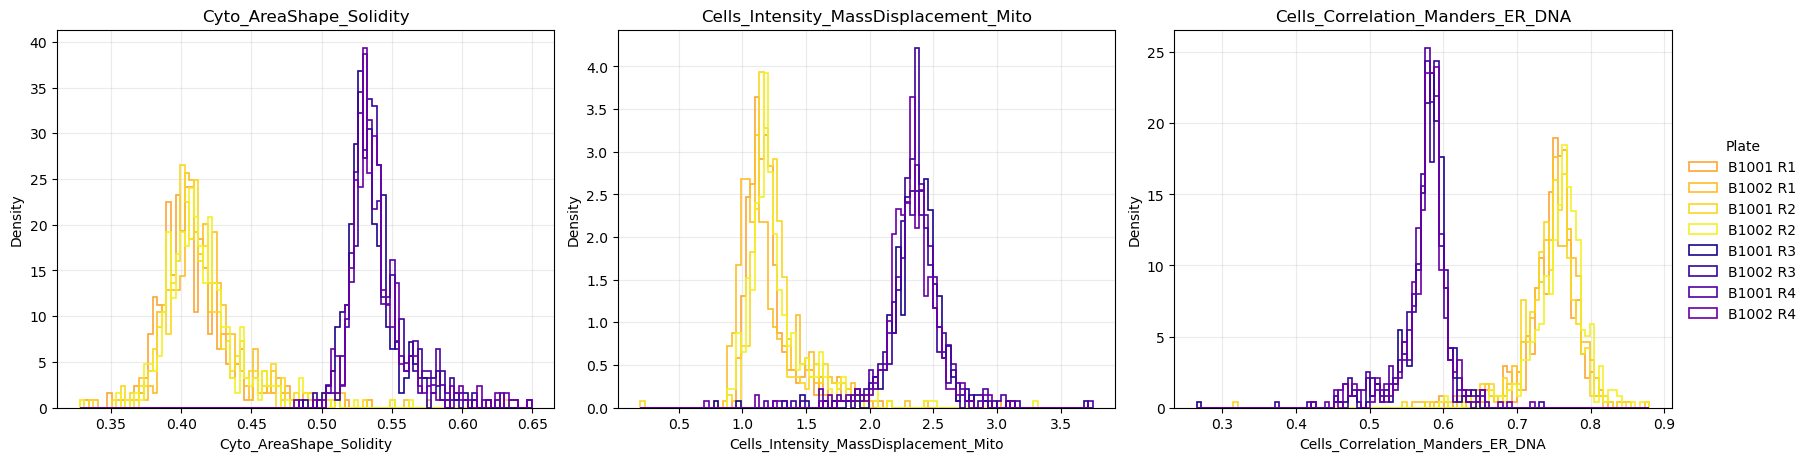

In [25]:
import numpy as np
import matplotlib.pyplot as plt

plates = [
    'HepG_MEDINA_B1001_R1',
    'HepG_MEDINA_B1002_R1',
    'HepG_MEDINA_B1001_R2',
    'HepG_MEDINA_B1002_R2',
    'HepG_MEDINA_B1001_R3',
    'HepG_MEDINA_B1002_R3',
    'HepG_MEDINA_B1001_R4',
    'HepG_MEDINA_B1002_R4',
]

columns = [
    'Cyto_AreaShape_Solidity',
    'Cells_Intensity_MassDisplacement_Mito',
    'Cells_Correlation_Manders_ER_DNA'
]

plasma = plt.cm.plasma
yellow_shades = [plasma(x) for x in np.linspace(0.80, 0.98, 4)]
purple_shades = [plasma(x) for x in np.linspace(0.02, 0.20, 4)]
colors = yellow_shades + purple_shades

labels = [
    'B1001 R1','B1002 R1','B1001 R2','B1002 R2',
    'B1001 R3','B1002 R3','B1001 R4','B1002 R4'
]

def plot_distributions(ax, series_list, labels, colors, nbins=100):
    data_min = min(np.nanmin(s) for s in series_list if s.size > 0)
    data_max = max(np.nanmax(s) for s in series_list if s.size > 0)
    if not np.isfinite(data_min) or not np.isfinite(data_max) or data_min == data_max:
        data_min, data_max = 0.0, 1.0
    bins = np.linspace(data_min, data_max, nbins)
    for s, lab, c in zip(series_list, labels, colors):
        s = s[np.isfinite(s)]
        if s.size == 0:
            continue
        ax.hist(s, bins=bins, density=True, histtype='step', linewidth=1.2, color=c, label=lab)
    ax.grid(True, alpha=0.25)

fig, axes = plt.subplots(1, 3, figsize=(18, 4.5), constrained_layout=True)

for ax, col in zip(axes, columns):
    series_list = []
    for p in plates:
        s = df.loc[df['Metadata_Unique_plate'] == p, col].to_numpy()
        series_list.append(s)
    plot_distributions(ax, series_list, labels, colors)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

handles, leg_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, leg_labels, loc='outside right', title='Plate', frameon=False)

plt.show()


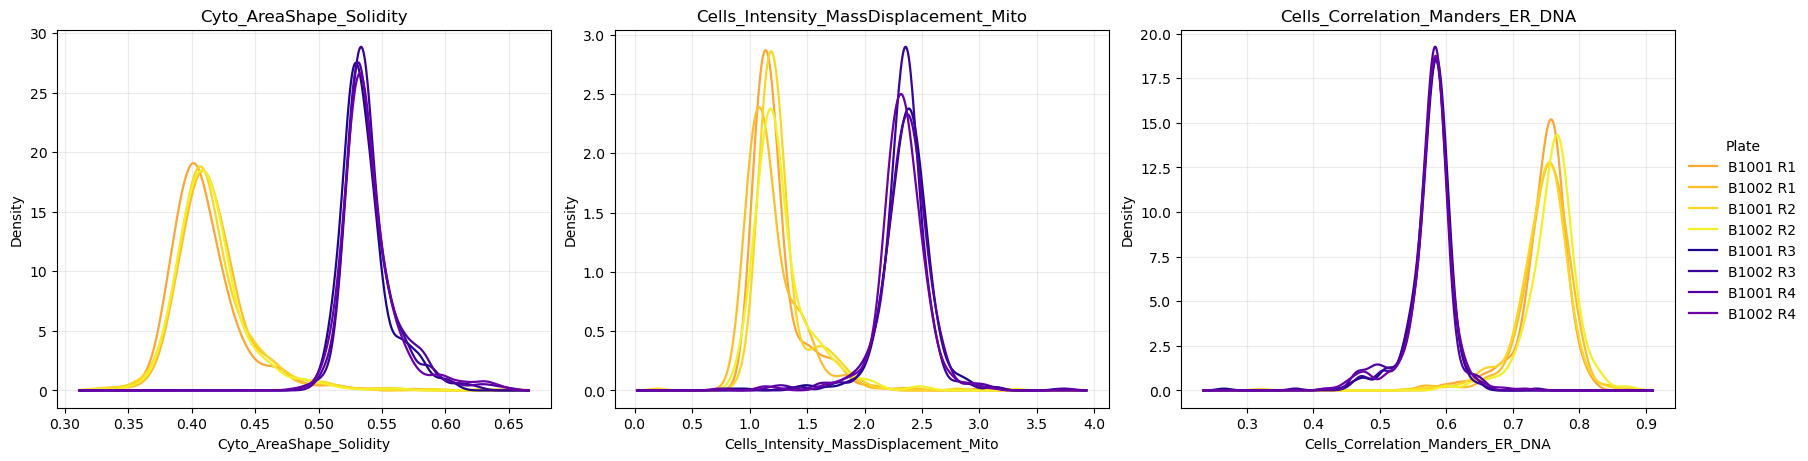

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

plates = [
    'HepG_MEDINA_B1001_R1',
    'HepG_MEDINA_B1002_R1',
    'HepG_MEDINA_B1001_R2',
    'HepG_MEDINA_B1002_R2',
    'HepG_MEDINA_B1001_R3',
    'HepG_MEDINA_B1002_R3',
    'HepG_MEDINA_B1001_R4',
    'HepG_MEDINA_B1002_R4',
]

columns = [
    'Cyto_AreaShape_Solidity',
    'Cells_Intensity_MassDisplacement_Mito',
    'Cells_Correlation_Manders_ER_DNA'
]

plasma = plt.cm.plasma
yellow_shades = [plasma(x) for x in np.linspace(0.80, 0.98, 4)]
purple_shades = [plasma(x) for x in np.linspace(0.02, 0.20, 4)]
colors = yellow_shades + purple_shades

labels = [
    'B1001 R1','B1002 R1','B1001 R2','B1002 R2',
    'B1001 R3','B1002 R3','B1001 R4','B1002 R4'
]

def kde_curve(y, xgrid, bw_method=None):
    """
    Fit Gaussian KDE on 1D data y and evaluate on xgrid.
    Returns zeros if y is empty or degenerate.
    """
    y = y[np.isfinite(y)]
    if y.size < 2 or np.nanstd(y) == 0:
        return np.zeros_like(xgrid)
    try:
        kde = gaussian_kde(y, bw_method=bw_method) 
        return kde.evaluate(xgrid)
    except Exception:
        return np.zeros_like(xgrid)

def plot_kde_overlays(ax, series_list, labels, colors, bw_method=None):
    """
    Draw smoothed PDFs with Gaussian KDE on a shared x-grid.
    """
    # common range with 5% padding
    data_min = min(np.nanmin(s[np.isfinite(s)]) for s in series_list if np.isfinite(s).any())
    data_max = max(np.nanmax(s[np.isfinite(s)]) for s in series_list if np.isfinite(s).any())
    if not np.isfinite(data_min) or not np.isfinite(data_max) or data_min == data_max:
        data_min, data_max = 0.0, 1.0
    pad = 0.05 * (data_max - data_min) if data_max > data_min else 0.05
    xgrid = np.linspace(data_min - pad, data_max + pad, 512)

    for s, lab, c in zip(series_list, labels, colors):
        pdf = kde_curve(s, xgrid, bw_method=bw_method)
        ax.plot(xgrid, pdf, linewidth=1.6, color=c, label=lab)

    ax.grid(True, alpha=0.25)
    ax.set_ylabel('Density')

fig, axes = plt.subplots(1, 3, figsize=(18, 4.5), constrained_layout=True)


bw = None

for ax, col in zip(axes, columns):
    series_list = [df.loc[df['Metadata_Unique_plate'] == p, col].to_numpy() for p in plates]
    plot_kde_overlays(ax, series_list, labels, colors, bw_method=bw)
    ax.set_title(col)
    ax.set_xlabel(col)

# one legend for all
handles, leg_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, leg_labels, loc='outside right', title='Plate', frameon=False)

plt.savefig('KDE.pdf',dpi = 1000)
plt.show()


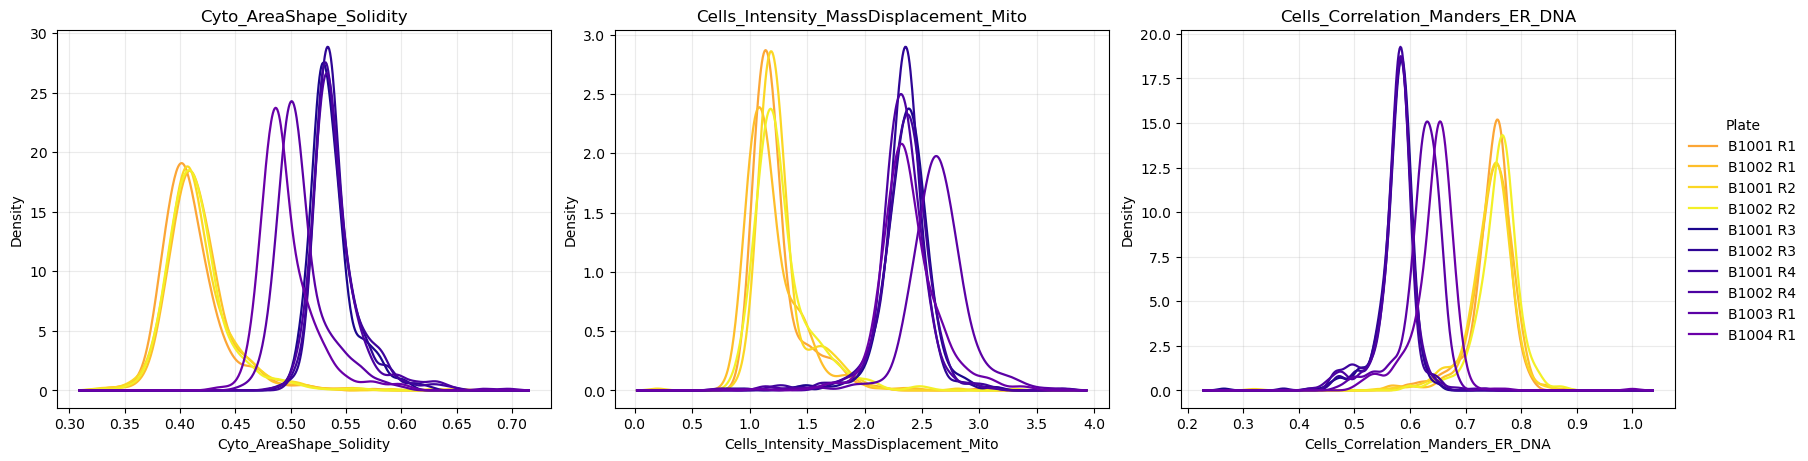

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ---- configuration ----
plates = [
    'HepG_MEDINA_B1001_R1',
    'HepG_MEDINA_B1002_R1',
    'HepG_MEDINA_B1001_R2',
    'HepG_MEDINA_B1002_R2',
    'HepG_MEDINA_B1001_R3',
    'HepG_MEDINA_B1002_R3',
    'HepG_MEDINA_B1001_R4',
    'HepG_MEDINA_B1002_R4',
    'HepG_MEDINA_B1003_R1',
    'HepG_MEDINA_B1004_R1'
]

columns = [
    'Cyto_AreaShape_Solidity',
    'Cells_Intensity_MassDisplacement_Mito',
    'Cells_Correlation_Manders_ER_DNA'
]

# First 4 = yellow family, last 4 = purple family from plasma
plasma = plt.cm.plasma
yellow_shades = [plasma(x) for x in np.linspace(0.80, 0.98, 4)]
purple_shades = [plasma(x) for x in np.linspace(0.02, 0.20, 6)]
colors = yellow_shades + purple_shades

labels = [
    'B1001 R1','B1002 R1','B1001 R2','B1002 R2',
    'B1001 R3','B1002 R3','B1001 R4','B1002 R4',
    'B1003 R1', 'B1004 R1'
]

def kde_curve(y, xgrid, bw_method=None):
    """
    Fit Gaussian KDE on 1D data y and evaluate on xgrid.
    Returns zeros if y is empty or degenerate.
    """
    y = y[np.isfinite(y)]
    if y.size < 2 or np.nanstd(y) == 0:
        return np.zeros_like(xgrid)
    try:
        kde = gaussian_kde(y, bw_method=bw_method)  # Scott's rule by default
        return kde.evaluate(xgrid)
    except Exception:
        return np.zeros_like(xgrid)

def plot_kde_overlays(ax, series_list, labels, colors, bw_method=None):
    """
    Draw smoothed PDFs with Gaussian KDE on a shared x-grid.
    """
    # common range with 5% padding
    data_min = min(np.nanmin(s[np.isfinite(s)]) for s in series_list if np.isfinite(s).any())
    data_max = max(np.nanmax(s[np.isfinite(s)]) for s in series_list if np.isfinite(s).any())
    if not np.isfinite(data_min) or not np.isfinite(data_max) or data_min == data_max:
        data_min, data_max = 0.0, 1.0
    pad = 0.05 * (data_max - data_min) if data_max > data_min else 0.05
    xgrid = np.linspace(data_min - pad, data_max + pad, 512)

    for s, lab, c in zip(series_list, labels, colors):
        pdf = kde_curve(s, xgrid, bw_method=bw_method)
        ax.plot(xgrid, pdf, linewidth=1.6, color=c, label=lab)

    ax.grid(True, alpha=0.25)
    ax.set_ylabel('Density')

# ---- build figure ----
fig, axes = plt.subplots(1, 3, figsize=(18, 4.5), constrained_layout=True)

# Optional: tune bandwidth (None uses Scott's rule; you can try 0.8, 1.0, 1.2, etc.)
bw = None

for ax, col in zip(axes, columns):
    series_list = [df.loc[df['Metadata_Unique_plate'] == p, col].to_numpy() for p in plates]
    plot_kde_overlays(ax, series_list, labels, colors, bw_method=bw)
    ax.set_title(col)
    ax.set_xlabel(col)

# one legend for all
handles, leg_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, leg_labels, loc='outside right', title='Plate', frameon=False)

plt.savefig('KDE')
plt.show()


## Task 2:

In [20]:
def save_single_plot(df, site="MEDINA", rep="R2", plate="B1004",
                     color_scale="site", outdir="plots", cmap_name="plasma"):
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    from pathlib import Path
    import numpy as np

    letters = [chr(ord("A")+i) for i in range(16)]
    letter_to_idx = {L: i for i,L in enumerate(letters)}
    numbers = list(range(1,25))

    def make_grid(sub_df):
        grid = np.full((16,24), np.nan, dtype=float)
        if not sub_df.empty:
            g = sub_df.groupby(["Metadata_Row","Metadata_Col"])["Metadata_Object_Count"].mean()
            for (r,c), v in g.items():
                grid[letter_to_idx[r], int(c)-1] = v
        return grid

    data = df.copy()
    data["Metadata_Row"] = data["Metadata_Row"].astype(str).str.upper()
    data["Metadata_Col"] = pd.to_numeric(data["Metadata_Col"], errors="coerce")
    data["Metadata_Object_Count"] = pd.to_numeric(data["Metadata_Object_Count"], errors="coerce")
    data = data[data["Metadata_Row"].isin(letters) & data["Metadata_Col"].between(1,24)]

    site_df = data[data["Metadata_Site"] == site]
    sub = site_df[(site_df["Metadata_Replicate"] == rep) & (site_df["Metadata_Plate_num"] == plate)]

    if color_scale == "site":
        vmin = site_df["Metadata_Object_Count"].min()
        vmax = site_df["Metadata_Object_Count"].max()
    elif color_scale == "global":
        vmin = data["Metadata_Object_Count"].min()
        vmax = data["Metadata_Object_Count"].max()
    else:
        raise ValueError("color_scale must be 'site' or 'global'")

    if pd.isna(vmin) or pd.isna(vmax) or vmin == vmax:
        vmin, vmax = 0.0, 1.0

    cmap = plt.cm.get_cmap(cmap_name).copy()
    cmap.set_bad(color="grey")

    fig, ax = plt.subplots(figsize=(6,5))
    ax.imshow(make_grid(sub), interpolation="nearest",
              cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax), aspect="auto")
    ax.set_title(f"{site} — {rep} | {plate}")
    ax.set_yticks(range(16)); ax.set_yticklabels(letters, fontsize=7)
    ax.set_xticks(range(24)); ax.set_xticklabels(numbers, fontsize=6, rotation=90)

    sm = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=cmap); sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.01).set_label("Metadata_Object_Count")
    fig.text(0.995, 0.02, "Grey = no data", ha="right", va="center", fontsize=8)

    Path(outdir).mkdir(parents=True, exist_ok=True)
    outpath = Path(outdir) / f"{site}_{rep}_{plate}_{color_scale}.pdf"
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved plot to {outpath}")


In [22]:
save_single_plot(df_small, site="MEDINA", rep="R2", plate="B1004",
                 color_scale="site", outdir="plots")


Saved plot to plots/MEDINA_R2_B1004_site.pdf


/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_7211/186658174.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name).copy()


In [29]:
df

,Metadata_Well,Metadata_Object_Count,Nuc_AreaShape_Area,Nuc_AreaShape_BoundingBoxArea,Nuc_AreaShape_BoundingBoxMaximum_X,Nuc_AreaShape_BoundingBoxMaximum_Y,Nuc_AreaShape_BoundingBoxMinimum_X,Nuc_AreaShape_BoundingBoxMinimum_Y,Nuc_AreaShape_Center_X,Nuc_AreaShape_Center_Y,...,Metadata_Unique_plate,Metadata_EOS,Metadata_Concentration,Metadata_Partner,Metadata_Row,Metadata_Col,Metadata_Compound_type,Metadata_DMSO,Metadata_Nocodazole,Metadata_Tetrandrine
0,A01,700,665.0,905.0,536.5,509.5,506.5,480.5,523.011597,494.002640,...,HepG_FMP_B1001_R1,EOS100001,10,Bioactives,A,1,EOS,False,False,False
1,A02,890,627.5,864.0,519.0,514.0,487.0,481.0,504.911392,496.798447,...,HepG_FMP_B1001_R1,EOS100089,10,Bioactives,A,2,EOS,False,False,False
2,A03,742,631.5,899.0,551.0,576.5,516.5,542.5,535.364777,556.941528,...,HepG_FMP_B1001_R1,EOS100009,10,Bioactives,A,3,EOS,False,False,False
3,A04,840,606.0,840.0,593.5,542.5,560.0,514.5,574.513031,528.910034,...,HepG_FMP_B1001_R1,EOS100097,10,Bioactives,A,4,EOS,False,False,False
4,A05,91,506.0,690.0,452.0,549.0,427.0,529.0,440.138550,538.330505,...,HepG_FMP_B1001_R1,EOS100017,10,Bioactives,A,5,EOS,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42842,P20,1105,458.0,624.0,580.0,601.0,555.0,574.0,566.545288,588.128296,...,HepG_USC_B1007_R2,EOS102456,10,Bioactives,P,20,EOS,False,False,False
42843,P21,1293,433.0,598.0,531.0,638.0,507.0,605.0,518.472046,621.702759,...,HepG_USC_B1007_R2,EOS102376,10,Bioactives,P,21,EOS,False,False,False
42844,P22,1355,429.0,580.0,563.0,522.0,536.0,494.0,547.828003,506.057129,...,HepG_USC_B1007_R2,EOS102464,10,Bioactives,P,22,EOS,False,False,False
42845,P23,1445,372.0,506.0,579.0,540.0,550.0,511.0,563.848877,525.885315,...,HepG_USC_B1007_R2,Tetrandrine,5,Bioactives,P,23,Tetrandrine,False,False,True


In [30]:
df_zoom = df[df['Metadata_Unique_plate'] == 'HepG_MEDINA_B1004_R2']

In [31]:
df_zoom

,Metadata_Well,Metadata_Object_Count,Nuc_AreaShape_Area,Nuc_AreaShape_BoundingBoxArea,Nuc_AreaShape_BoundingBoxMaximum_X,Nuc_AreaShape_BoundingBoxMaximum_Y,Nuc_AreaShape_BoundingBoxMinimum_X,Nuc_AreaShape_BoundingBoxMinimum_Y,Nuc_AreaShape_Center_X,Nuc_AreaShape_Center_Y,...,Metadata_Unique_plate,Metadata_EOS,Metadata_Concentration,Metadata_Partner,Metadata_Row,Metadata_Col,Metadata_Compound_type,Metadata_DMSO,Metadata_Nocodazole,Metadata_Tetrandrine
26349,A01,816,536.5,754.0,546.5,645.0,519.0,617.5,530.906616,629.441132,...,HepG_MEDINA_B1004_R2,EOS101057,10,Bioactives,A,1,EOS,False,False,False
26350,A02,939,529.0,744.0,506.0,635.0,473.0,607.0,486.900818,620.868896,...,HepG_MEDINA_B1004_R2,EOS101145,10,Bioactives,A,2,EOS,False,False,False
26351,A03,1362,510.0,720.0,519.0,445.0,490.0,417.5,504.662033,431.851685,...,HepG_MEDINA_B1004_R2,EOS101065,10,Bioactives,A,3,EOS,False,False,False
26352,A04,1322,501.5,700.0,572.0,649.0,544.5,623.0,559.155792,636.910278,...,HepG_MEDINA_B1004_R2,EOS101153,10,Bioactives,A,4,EOS,False,False,False
26353,A05,1123,471.0,650.0,516.0,577.0,488.0,552.0,501.248138,562.238708,...,HepG_MEDINA_B1004_R2,EOS101073,10,Bioactives,A,5,EOS,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26728,P20,740,358.0,493.5,569.5,576.0,543.5,545.0,555.434692,560.110016,...,HepG_MEDINA_B1004_R2,EOS101400,10,Bioactives,P,20,EOS,False,False,False
26729,P21,1947,480.0,672.0,572.0,508.0,542.0,478.0,557.104065,493.041382,...,HepG_MEDINA_B1004_R2,EOS101320,10,Bioactives,P,21,EOS,False,False,False
26730,P22,1748,488.0,676.0,611.5,597.0,582.0,568.5,597.199921,582.323608,...,HepG_MEDINA_B1004_R2,EOS101408,10,Bioactives,P,22,EOS,False,False,False
26731,P23,721,390.0,540.0,620.0,629.0,591.0,606.0,603.539978,616.509033,...,HepG_MEDINA_B1004_R2,Tetrandrine,5,Bioactives,P,23,Tetrandrine,False,False,True


In [32]:
odd_letters  = {chr(c) for c in range(ord('A'), ord('P')+1) if (c - ord('A')) % 2 == 0}
even_letters = {chr(c) for c in range(ord('A'), ord('P')+1) if (c - ord('A')) % 2 == 1}

first_char = df_zoom['Metadata_Well'].astype(str).str[0]

df_zoom_odd  = df_zoom[first_char.isin(odd_letters)].copy()   # A, C, E, ..., O
df_zoom_even = df_zoom[first_char.isin(even_letters)].copy()  # B, D, F, ..., P



In [33]:
df_zoom_odd

,Metadata_Well,Metadata_Object_Count,Nuc_AreaShape_Area,Nuc_AreaShape_BoundingBoxArea,Nuc_AreaShape_BoundingBoxMaximum_X,Nuc_AreaShape_BoundingBoxMaximum_Y,Nuc_AreaShape_BoundingBoxMinimum_X,Nuc_AreaShape_BoundingBoxMinimum_Y,Nuc_AreaShape_Center_X,Nuc_AreaShape_Center_Y,...,Metadata_Unique_plate,Metadata_EOS,Metadata_Concentration,Metadata_Partner,Metadata_Row,Metadata_Col,Metadata_Compound_type,Metadata_DMSO,Metadata_Nocodazole,Metadata_Tetrandrine
26349,A01,816,536.5,754.0,546.5,645.0,519.0,617.5,530.906616,629.441132,...,HepG_MEDINA_B1004_R2,EOS101057,10,Bioactives,A,1,EOS,False,False,False
26350,A02,939,529.0,744.0,506.0,635.0,473.0,607.0,486.900818,620.868896,...,HepG_MEDINA_B1004_R2,EOS101145,10,Bioactives,A,2,EOS,False,False,False
26351,A03,1362,510.0,720.0,519.0,445.0,490.0,417.5,504.662033,431.851685,...,HepG_MEDINA_B1004_R2,EOS101065,10,Bioactives,A,3,EOS,False,False,False
26352,A04,1322,501.5,700.0,572.0,649.0,544.5,623.0,559.155792,636.910278,...,HepG_MEDINA_B1004_R2,EOS101153,10,Bioactives,A,4,EOS,False,False,False
26353,A05,1123,471.0,650.0,516.0,577.0,488.0,552.0,501.248138,562.238708,...,HepG_MEDINA_B1004_R2,EOS101073,10,Bioactives,A,5,EOS,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26704,O20,1586,500.0,702.0,505.5,614.5,476.0,584.0,490.935196,599.391296,...,HepG_MEDINA_B1004_R2,EOS101224,10,Bioactives,O,20,EOS,False,False,False
26705,O21,1726,496.5,702.0,549.0,604.5,521.0,575.0,534.654480,590.254974,...,HepG_MEDINA_B1004_R2,EOS101144,10,Bioactives,O,21,EOS,False,False,False
26706,O22,1634,501.0,700.0,605.5,592.5,574.0,561.0,587.962952,575.307159,...,HepG_MEDINA_B1004_R2,EOS101232,10,Bioactives,O,22,EOS,False,False,False
26707,O23,833,606.0,840.0,594.0,552.0,563.0,524.0,579.975586,538.288635,...,HepG_MEDINA_B1004_R2,Nocodazole,5,Bioactives,O,23,Nocodazole,False,True,False


In [34]:
import numpy as np
import pandas as pd
from scipy import stats

def _bh_fdr(pvals):
    p = np.asarray(pvals, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    q = ranked * n / (np.arange(1, n+1))
    q = np.minimum.accumulate(q[::-1])[::-1]
    out = np.empty_like(q)
    out[order] = q
    return np.minimum(out, 1.0)

def compare_dataframes(
    df1, df2,
    max_levels=1000,
    rare_level_min_count=0,
    use_g_test=False
):
    cols = [c for c in df1.columns if c in df2.columns]
    results = []

    for col in cols:
        s1 = df1[col].dropna()
        s2 = df2[col].dropna()
        if len(s1) == 0 or len(s2) == 0:
            continue

        if np.issubdtype(s1.dtype, np.number) and np.issubdtype(s2.dtype, np.number):
            kind = 'numeric'
        else:
            kind = 'categorical'

        test_name = None
        pval = np.nan
        effect = np.nan
        extra = {}

        if kind == 'numeric':
            t, pval = stats.ttest_ind(s1, s2, equal_var=False, nan_policy='omit')
            m1, m2 = np.mean(s1), np.mean(s2)
            v1, v2 = np.var(s1, ddof=1), np.var(s2, ddof=1)
            n1, n2 = len(s1), len(s2)
            sp2 = ((n1-1)*v1 + (n2-1)*v2) / (n1 + n2 - 2) if (n1+n2-2) > 0 else np.nan
            sd_pooled = np.sqrt(sp2) if sp2 >= 0 else np.nan
            effect = (m1 - m2) / sd_pooled if sd_pooled and sd_pooled > 0 else np.nan
            extra = {
                'mean_df1': m1, 'mean_df2': m2,
                'diff_means': m1 - m2,
                'sd_df1': np.sqrt(v1), 'sd_df2': np.sqrt(v2),
                'n_df1': n1, 'n_df2': n2
            }
            test_name = 'Welch t-test (means)'

        else:
            s1 = s1.astype('object')
            s2 = s2.astype('object')
            cats = pd.Index(pd.unique(pd.concat([s1, s2], ignore_index=True)))

            if len(cats) == 2:
                uniq_sorted = pd.Index(sorted(cats))
                ref = uniq_sorted[0]
                s1b = (s1 == ref).astype(int)
                s2b = (s2 == ref).astype(int)
                x1, n1 = int(s1b.sum()), len(s1b)
                x2, n2 = int(s2b.sum()), len(s2b)
                p1, p2 = x1/n1, x2/n2
                p_pool = (x1 + x2) / (n1 + n2)
                se = np.sqrt(p_pool*(1-p_pool)*(1/n1 + 1/n2))
                if se == 0:
                    z = np.inf if p1 != p2 else 0.0
                    pval = 0.0 if np.isfinite(z) and z != 0 else 1.0
                else:
                    z = (p1 - p2) / se
                    pval = 2 * (1 - stats.norm.cdf(abs(z)))
                effect = p1 - p2
                extra = {'prop_df1': p1, 'prop_df2': p2, 'n_df1': n1, 'n_df2': n2}
                test_name = 'Two-proportion z-test'

            else:
                if len(cats) > max_levels:
                    results.append({
                        'column': col, 'type': 'categorical',
                        'test': f'Skipped: >{max_levels} levels',
                        'p_value': np.nan, 'effect_size': np.nan, 'levels': len(cats)
                    })
                    continue

                c1 = pd.value_counts(pd.Categorical(s1, categories=cats))
                c2 = pd.value_counts(pd.Categorical(s2, categories=cats))
                table = np.vstack([c1.values, c2.values])

                if rare_level_min_count and rare_level_min_count > 0:
                    totals = table.sum(axis=0)
                    rare_mask = totals < rare_level_min_count
                    if rare_mask.any():
                        rare_sum = table[:, rare_mask].sum(axis=1, keepdims=True)
                        table = np.hstack([table[:, ~rare_mask], rare_sum])
                        kept_cats = list(cats[~rare_mask]) + ['OTHER']
                    else:
                        kept_cats = list(cats)
                else:
                    kept_cats = list(cats)

                keep = table.sum(axis=0) > 0
                table = table[:, keep]
                kept_cats = [c for c, k in zip(kept_cats, keep) if k]

                if table.shape[1] < 2 or (table.sum(axis=1) == 0).any():
                    results.append({
                        'column': col, 'type': 'categorical',
                        'test': 'Chi-square/G-test not applicable',
                        'p_value': np.nan, 'effect_size': np.nan,
                        'levels_kept': len(kept_cats)
                    })
                    continue

                if use_g_test:
                    stat, pval, dof, exp = stats.power_divergence(
                        f_obs=table, correction=False, lambda_="log-likelihood"
                    )
                    test_name = 'G-test (log-likelihood ratio)'
                else:
                    stat, pval, dof, exp = stats.chi2_contingency(table, correction=False)
                    test_name = 'Chi-square (distribution)'

                n_tot = table.sum()
                k = min(table.shape) - 1
                effect = np.sqrt(stat / (n_tot * k)) if n_tot > 0 and k > 0 else np.nan

                extra = {
                    'levels_kept': kept_cats,
                    'counts_df1': table[0].tolist(),
                    'counts_df2': table[1].tolist()
                }

        results.append({
            'column': col,
            'type': 'numeric' if np.issubdtype(df1[col].dtype, np.number) and np.issubdtype(df2[col].dtype, np.number) else 'categorical',
            'test': test_name,
            'p_value': pval,
            'effect_size': effect,
            **extra
        })

    out = pd.DataFrame(results)
    if out.empty:
        return out

    valid = out['p_value'].notna()
    adj = np.full(len(out), np.nan)
    if valid.any():
        adj[valid.values] = _bh_fdr(out.loc[valid, 'p_value'].values)
    out['p_adj_fdr_bh'] = adj

    out = out.sort_values(['p_adj_fdr_bh', 'p_value'], ascending=True, na_position='last').reset_index(drop=True)
    return out


In [35]:
summary = compare_dataframes(df_zoom_odd, df_zoom_even)
summary.head(40)['column']


/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_69779/2817794331.py:111: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  c1 = pd.value_counts(pd.Categorical(s1, categories=cats))
/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_69779/2817794331.py:112: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  c2 = pd.value_counts(pd.Categorical(s2, categories=cats))
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_69779/2817794331.py:111: FutureWarning: pandas.value_counts is deprecated and will be remove

0                  Nuc_Texture_SumAverage_Mito_5_01_256
1                  Nuc_Texture_SumAverage_Mito_5_00_256
2                 Nuc_Texture_SumAverage_Mito_10_00_256
3                  Nuc_Texture_SumAverage_Mito_5_03_256
4                  Nuc_Texture_SumAverage_Mito_3_03_256
5                  Nuc_Texture_SumAverage_Mito_5_02_256
6                  Nuc_Texture_SumAverage_Mito_3_01_256
7     Nuc_Texture_InverseDifferenceMoment_Mito_3_00_256
8                  Nuc_Texture_SumAverage_Mito_3_02_256
9                  Nuc_Texture_SumAverage_Mito_3_00_256
10                Nuc_Texture_SumAverage_Mito_10_02_256
11    Nuc_Texture_InverseDifferenceMoment_Mito_3_01_256
12                     Nuc_Intensity_MeanIntensity_Mito
13                Nuc_Texture_SumAverage_Mito_10_01_256
14    Nuc_Texture_InverseDifferenceMoment_Mito_3_02_256
15    Nuc_Texture_InverseDifferenceMoment_Mito_5_02_256
16    Nuc_Texture_InverseDifferenceMoment_Mito_5_00_256
17                Nuc_Texture_SumAverage_Mito_10